# Guru strategies

In this analysis seven guru strategies will be tested on companies from Warsaw Stock Exchange. These strategies were created basing on NYSE in various years. The benchmark of these strategies would be Benjamin Graham's *zero effort strategy* assuming investing in just market index (in this case Warsaw Stock Exchange Index).

The analyzed dataset was created with data from biznesradar.pl website and contains information from WSE companies' financial reports and some economic indices like USD/PLN exchange rate, GDP of Poland, unemployment rate etc., as well as all necessary indices for checking guru strategies. Each strategy would be tested only for observations, which provide all indices required by given strategy. The dataset covers 69 quarters from Q4 2004 to Q4 2021.

The purpose of this analysis is to check if given strategy properly classifies companies, which prices increased the most in given period of time (including capital gains tax -19% in Poland - and inflation rate).

These principles are the fundamentals of this analysis:
1. First of all, do not lose - a preferred strategy is *not loss-making*, even if it brings only small profits.
2. Assume the profit threshold you want to achieve within given period of time by buying shares of a given company.
3. If the company has achieved the assumed profit treshold within given period of time from purchase, sell it.
4. If the company has not achieved the assumed profit after a given period of time, sell it.

In [26]:
# Packages loading
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from textwrap import wrap

In [27]:
# Dataset loading (the newest full dataset)
dataset = pd.read_csv(
    max(
        glob.glob(os.getcwd().replace('analysis', '') + 'data\\full_datasets\\*.csv'),
        key = os.path.getctime
    ),
    index_col=False,
    low_memory=False
)

C:\Users\U157766\AppData\Local\Temp\ipykernel_14928\3416461240.py:2: DtypeWarning: Columns (439,442) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(


In [96]:
# Custom functions and other option changes

def custom_heatmap(cross_tab, ax):
    """Function for simpler creating heatmaps"""
    return sns.heatmap(
        data=cross_tab,
        cmap='Blues',
        fmt='.0%',
        annot=True,
        cbar=False,
        ax=ax
    )

def strategy_stat(data_frame, return_data_frame, portfolio_data_frame, strategy_name):
    """Function printing strategy's performance statistics"""

    quarters_strat = return_data_frame[strategy_name].count()

    portfolio_size = portfolio_data_frame[
        portfolio_data_frame[strategy_name] >= 10
    ][strategy_name].count()

    quarters_profit_strat = return_data_frame[
        return_data_frame[strategy_name] > 0
    ][strategy_name].count()

    quarters_profit_wig = return_data_frame[
        return_data_frame['Zero effort strategy'] > 0
    ]['Zero effort strategy'].count()

    quarters_perform_strat = return_data_frame[
        return_data_frame[strategy_name] > return_data_frame['Zero effort strategy']
    ][strategy_name].count()

    strategy_return = (100 * return_data_frame[strategy_name].sum()).round(2)
    avg_strategy_return = (100 * return_data_frame[strategy_name].mean()).round(2)

    wig_return = (100 * return_data_frame['Zero effort strategy'].sum()).round(2)
    avg_wig_return =(100 * return_data_frame['Zero effort strategy'].mean()).round(2)

    print(f'Number of quarters with buy signal from {strategy_name}: {quarters_strat}')
    print(f'Number of quarters with sufficient portfolio size: {portfolio_size}')
    print(f'Number of profitable quarters using {strategy_name}: {quarters_profit_strat}')
    print(f'Number of profitable quarters using zero effort strategy: {quarters_profit_wig}')
    print(f'Number of quarters in which {strategy_name} outperformed zero effort strategy: {quarters_perform_strat}')
    print(f'Total return on {strategy_name}: {strategy_return}%')
    print(f'Total return on zero effort strategy: {wig_return}%')
    print(f'Average return on {strategy_name}: {avg_strategy_return}%')
    print(f'Average return on zero effort strategy: {avg_wig_return}%')

quarters = sorted(dataset.quarter.unique())

pd.options.display.float_format = '{:.2f}'.format

The very first question is: what treshold value should be set? Too low will mean that we will sell the company's shares too early, when it could still achieve a higher profit. On the other hand, if we are too greedy, we may miss the price peak. In addition, setting the bar too high may result in a very small number of interesting companies. Or, if we want to outperform the zero effort strategy, maybe we should set the treshold higher than WIG dynamics in given quarter?

There is a rule attributed to Benjamin Graham that says to sell the shares when you reach 50-100% profit or after 2-3 years. However, conclusions made by Graham (or any other guru) were based on decades of NYSE functioning. Warsaw Stock Exchange is much younger - it has existed in its present form since 1991, and analyzed dataset contains data from early 2000s. A more reasonable period of time that we can give each company is therefore one year. With this assumpion we can set some features, which would represent price dynamics of each company.

The **best_price_dynamics_y** feature represents the best scenario dynamics of price in the following year, i.e.
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 101, 105, 103 and 104 respectively, the **best_price_dynamics_y** would be 0.05 (i.e. (105 - 100) / 100);
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 95, 96, 97 and 90 respectively, the **best_price_dynamics_y** would be -0.03 (i.e. (97 - 100) / 100).

The **price_dynamics_y** feature represents dynamics of price after the following year, e.g. dynamics between Q1 2020 and Q1 2021.

The **adj_best_price_dynamics_y** and **adj_price_dynamics_y** features represent **best_price_dynamics_y** and **price_dynamics_y** adjusted by capital gains tax and inflation rate. It does not include transaction fees, as they may vary depending on broker, transaction value etc.

Similar rules apply to **best_wig_dynamics_y** and **wig_dynamics_y**, except that these features represent dynamics of WIG (Warsaw Stock Exchange Index), which serves as a benchmark for each strategy.

In [29]:
# There is a wrong price reported by company FMG in Q4 2018. The company reported price at 0.15 - however, in neighbouring quarters it was 30.93 and 28. 
# Checking this information on another stock exchange website (stooq.pl) confirms that this is an incorrect value - this company was listed on the stock 
# exchange only once in Q4 2018, but with a price of 29, which is a better approximation of the real price.
idx = dataset.loc[
    np.where(
        (dataset.company_code == 'FMG')
        & (dataset.quarter == '2018/Q4')
    )  
].index[0]

dataset.loc[idx, 'price'] = 29
dataset.loc[idx, 'best_price_dynamics_y'] = (28 - 29) / 29
dataset.loc[idx, 'price_dynamics_y'] = (9 - 29) / 29

In [30]:
# Adding adjusted dynamics
dataset['adj_best_price_dynamics_y'] =  81 * dataset.best_price_dynamics_y / dataset.inflation_yy_m
dataset['adj_price_dynamics_y'] =  81 * dataset.price_dynamics_y / dataset.inflation_yy_m
dataset['adj_best_wig_dynamics_y'] =  81 * dataset.best_wig_dynamics_y / dataset.inflation_yy_m
dataset['adj_wig_dynamics_y'] =  81 * dataset.wig_dynamics_y / dataset.inflation_yy_m

When it comes to the profit treshold, we can look at the plot of adjusted best WIG dynamics in the following year. If we simply followed the zero effort strategy, our investments would only exceed the 50% threshold twice, and the average return on investment would be 12%. Hence, as for the conditions of the Warsaw Stock Exchange, a profit of 50% is quite satisfactory.

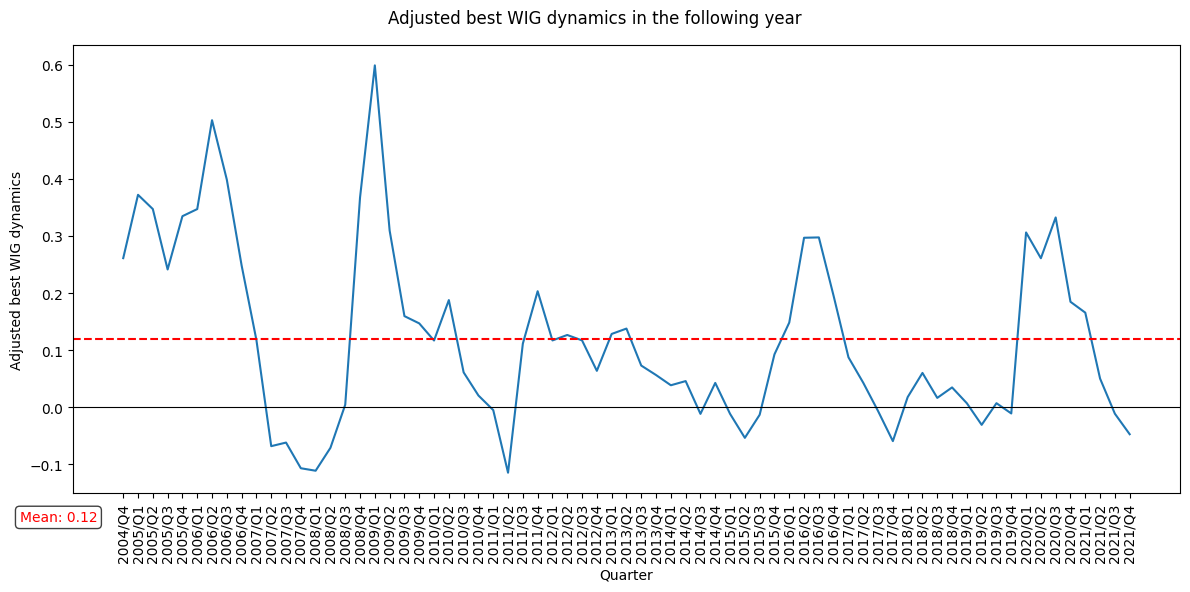

In [210]:
temp_df = dataset.filter(['quarter', 'adj_best_wig_dynamics_y']).groupby('quarter').mean()
temp_mean = temp_df.mean()[0]

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=temp_df,
    legend=False,
    ax=ax
)

ax.axhline(0, color='black', linewidth=.8)
ax.axhline(
    temp_df.mean()[0],
    color='red',
    linestyle='dashed'
)
ax.text(
    -7, -.2,
    f'Mean: {(temp_mean.round(2))}',
    color='red',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.75)
)

ax.tick_params(axis='x', labelrotation=90)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Quarter')
ax.set_ylabel('Adjusted best WIG dynamics')

plt.suptitle('Adjusted best WIG dynamics in the following year')

plt.tight_layout();

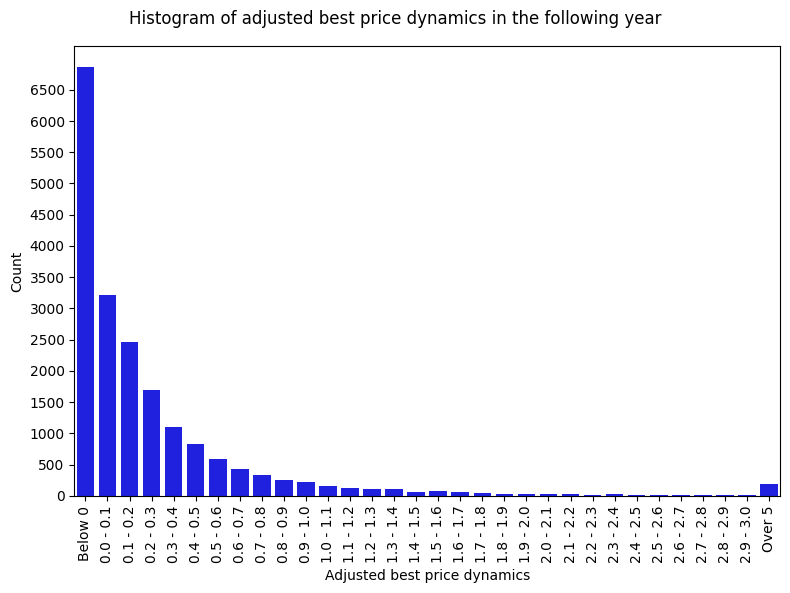

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        dataset.adj_best_price_dynamics_y,
        bins=[-.8] + list(np.arange(0, 3.1, .1)) + [67],
        labels=['Below 0'] + [f'{round(i, 1)} - {round(i + 0.1, 1)}' for i in np.arange(0, 3, .1)] + ['Over 5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)
plt.yticks(range(0, 7000, 500))

ax.set_xlabel('Adjusted best price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of adjusted best price dynamics in the following year')

plt.tight_layout();

Benjamin Graham recommended the portfolio of the minimum size from 10 (for his most defensive strategy) to 30. As we can see below, portfolios with treshold over 100% have long periods with their size below 10. On the other hand, portfolio with treshold equal 50% has size generally way over 30, but this gives a wide range of interesting companies.

In [33]:
# Temporary data frame with portfolio size depending on treshold
portfolio_df = pd.DataFrame(index=sorted(dataset.quarter.unique()))

for i in range(50, 225, 25):
    temp_price_df = dataset.filter(['quarter', 'adj_best_price_dynamics_y'])

    temp_price_df['sold_in_q'] = pd.Series(np.where(
        dataset.adj_best_price_dynamics_y > i/100,
        dataset.best_price_dynamics_in_q,
        dataset.price_dynamics_y_in_q
    ))

    temp_portfolio_df = pd.DataFrame(
        pd.Series(temp_price_df[
            temp_price_df.adj_best_price_dynamics_y > i/100
        ].groupby('quarter').quarter.count().reindex(sorted(dataset.quarter.unique())).fillna(0), name='buy')
    )
    temp_portfolio_df['sell'] = pd.Series(temp_price_df[
        temp_price_df.adj_best_price_dynamics_y > i/100
    ].groupby('sold_in_q').sold_in_q.count().reindex(sorted(dataset.quarter.unique())).fillna(0))

    portfolio_df[f'Treshold: {i}%'] = (temp_portfolio_df.buy - temp_portfolio_df.sell).cumsum()

print('Size of portfolio in each quarter depending on treshold:')
portfolio_df

Size of portfolio in each quarter depending on treshold:


Treshold: 50%  Treshold: 75%  Treshold: 100%  Treshold: 125%  \
2004/Q4          26.00          14.00           10.00            8.00   
2005/Q1           3.00           2.00            2.00            2.00   
2005/Q2           6.00           5.00            5.00            4.00   
2005/Q3           8.00           7.00            7.00            5.00   
2005/Q4          76.00          60.00           52.00           38.00   
...                ...            ...             ...             ...   
2020/Q4         544.00         373.00          253.00          188.00   
2021/Q1         319.00         196.00          112.00           79.00   
2021/Q2         190.00         116.00           62.00           44.00   
2021/Q3         106.00          64.00           39.00           26.00   
2021/Q4          49.00          28.00           16.00            9.00   

         Treshold: 150%  Treshold: 175%  Treshold: 200%  
2004/Q4            7.00            7.00            4.00  
2005/Q1            2.00            1.00            0.00  
2005/Q2            4.00            3.00            2.00  
2005/Q3            5.00            4.00            4.00  
2005/Q4           34.00           26.00           25.00  
...                 ...             ...             ...  
2020/Q4          142.00          102.00           87.00  
2021/Q1           61.00           40.00           30.00  
2021/Q2           35.00           24.00           19.00  
2021/Q3           21.00           19.00           15.00  
2021/Q4            5.00            5.00            4.00  

[69 rows x 7 columns]

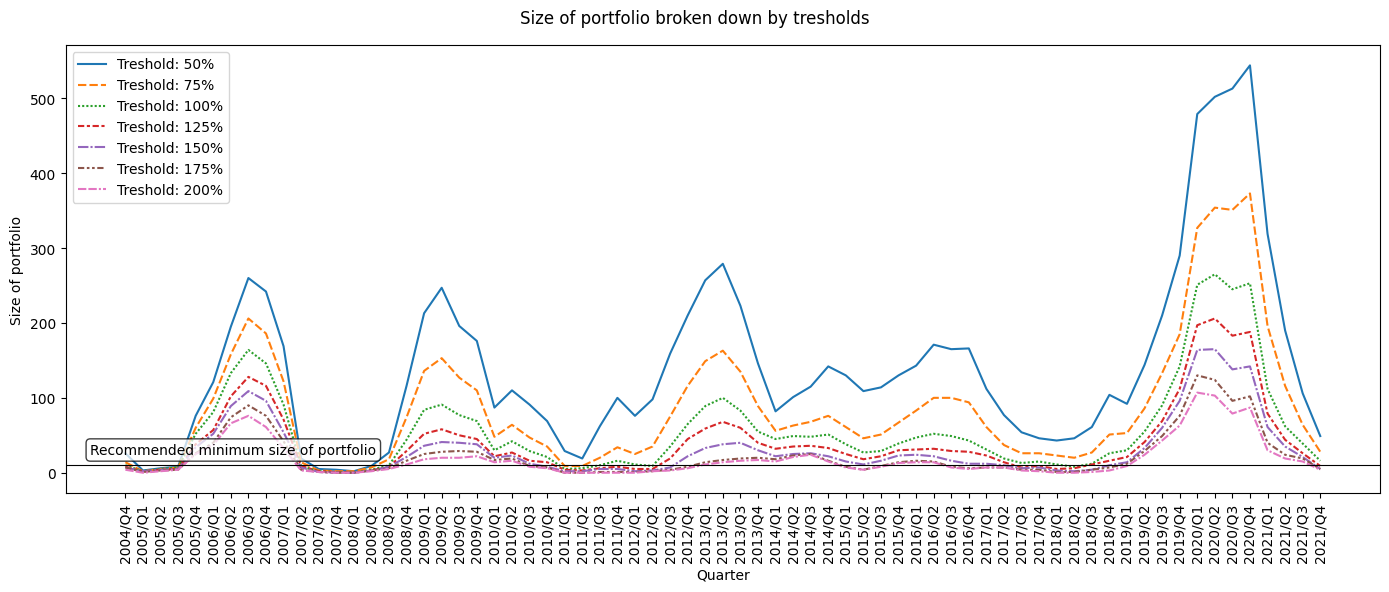

In [88]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=portfolio_df,
    ax=ax
)

ax.axhline(10, color='black', linewidth=.8)
ax.text(
    -2, 25,
    'Recommended minimum size of portfolio',
    color='black',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.75)
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Quarter')
ax.set_ylabel('Size of portfolio')

plt.suptitle('Size of portfolio broken down by tresholds')

plt.tight_layout();


Let's add **final_price_dynamics**, **final_wig_dynamics** and **interesting_investment** with treshold of 0.5 to the dataset - they would serve as temporary target features. The **final_price_dynamics** takes value of given treshold if **adj_best_price_dynamics_y** exceeds it and **price_dynamics_y** otherwise. Similarly works **final_wig_dynamics**. This logic is consistent with points 3. and 4. - we sell company if it reaches treshold or at the end of year regardless of its price. Finally, **interesting_company** is a variable which takes *Yes* if given company make a profit above the treshold, *Maybe* if company make a profit below the treshold and *No* if company make a loss.

*There is a huge gap between the 75th percentile (0.31) and maximum value (66.32) of **adj_best_price_dynamics_y**. However, such great increase in price values did happen in 2020 - the best example is MERCATOR, which price in 2019 was in the ballpark of a few PLNs, while in 2020 it skyrocketed to about 500 PLN. Although such observations may be seen as outliers, according to point 3. we sell company at given treshold anyway, so our investments would never achieve such high profit.*

In [35]:
print('The basic statistics of price and WIG dynamics:')
dataset[['adj_best_price_dynamics_y', 'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y']].describe()

The basic statistics of price and WIG dynamics:


adj_best_price_dynamics_y  adj_price_dynamics_y  \
count                   19162.00              19162.00   
mean                        0.27                  0.11   
std                         1.14                  1.11   
min                        -0.80                 -0.80   
25%                        -0.03                 -0.22   
50%                         0.08                 -0.01   
75%                         0.31                  0.22   
max                        66.32                 66.32   

       adj_best_wig_dynamics_y  adj_wig_dynamics_y  
count                 19162.00            19162.00  
mean                      0.10                0.04  
std                       0.13                0.18  
min                      -0.11               -0.40  
25%                       0.00               -0.08  
50%                       0.06                0.02  
75%                       0.17                0.15  
max                       0.60                0.60

In [36]:
# Adding final_price_dynamics, final_wig_dynamics and interesting_investment
dataset['final_price_dynamics'] = pd.Series(
    np.where(
        dataset.adj_best_price_dynamics_y > .5,
        .5, dataset.adj_price_dynamics_y
    )
)

dataset['final_wig_dynamics'] = pd.Series(
    np.where(
        dataset.adj_best_wig_dynamics_y > .5,
        .5, dataset.adj_wig_dynamics_y
    )
)

dataset['interesting_investment'] = pd.Categorical(
    pd.Series(
        np.where(
            dataset.final_price_dynamics == .5,
            'Yes', np.where(
                dataset.final_price_dynamics >= 0,
                'Maybe', 'No'
            )
        )
    ),
    categories=['No', 'Maybe', 'Yes'],
    ordered=True
)

dataset['sold_in_q'] = pd.Series(np.where(
    dataset.adj_best_price_dynamics_y > .5,
    dataset.best_price_dynamics_in_q,
    dataset.price_dynamics_y_in_q
))

Assuming the treshold at 0.5, there are 2998 interesting investments - about 15% of all observations. About 35% of observations made a profit below 50%. Half of companies actually reported loss in the following year, with -0.8 as minimum **final_price_dynamics**. The mean **final_price_dynamics** is 0.01: if we randomly invest in a company and keep with points 3. and 4., we would make a profit of 1%.

In [37]:
print('The basic statistics of final price dynamics:')
print(dataset.final_price_dynamics.describe())
print('\nThe count of interesting companies:')
print(dataset.interesting_investment.value_counts())

The basic statistics of final price dynamics:
count   19162.00
mean        0.01
std         0.31
min        -0.80
25%        -0.21
50%        -0.00
75%         0.24
max         0.50
Name: final_price_dynamics, dtype: float64

The count of interesting companies:
No       9609
Maybe    6551
Yes      3002
Name: interesting_investment, dtype: int64


In [38]:
print(f'Percentage of companies which made a profit over 50%:', end=' ')
print(round(100 * len(dataset[dataset.interesting_investment == 'Yes']) / len(dataset), 2), end='%')
print(f'\nPercentage of companies which made a profit below 50%:', end=' ')
print(round(100 * len(dataset[dataset.interesting_investment == 'Maybe']) / len(dataset), 2), end='%')
print(f'\nPercentage of companies which made a loss:', end=' ')
print(round(100 * len(dataset[dataset.interesting_investment == 'No']) / len(dataset), 2), end='%')

Percentage of companies which made a profit over 50%: 15.67%
Percentage of companies which made a profit below 50%: 34.19%
Percentage of companies which made a loss: 50.15%

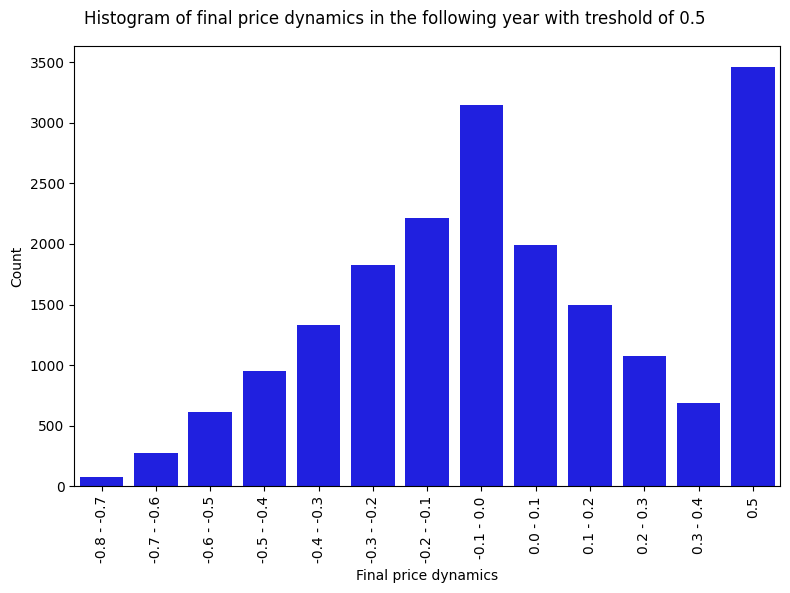

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        dataset.final_price_dynamics,
        bins=list(np.linspace(-.8, .5, 14)),
        labels=[f'{round(i, 1)} - {round(i + .1, 1)}' for i in np.linspace(-.8, .3, 12)] + ['0.5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of final price dynamics in the following year with treshold of 0.5')

plt.tight_layout();

The average final WIG dynamics is much lower than average best WIG dynamics: 6% vs 12% respectively.

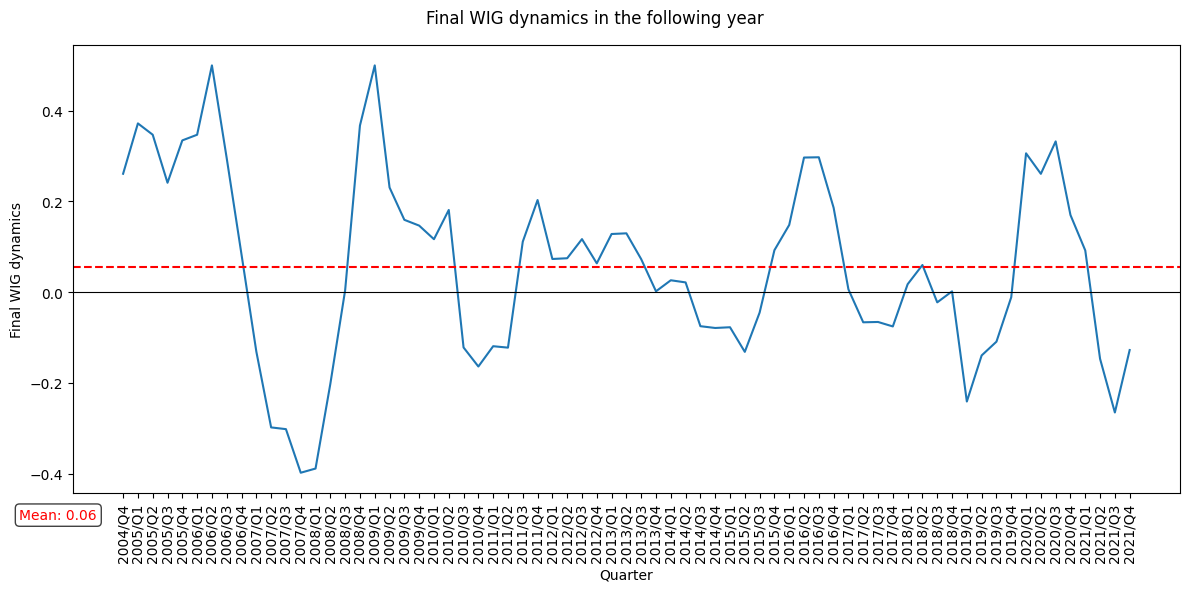

In [224]:
temp_df = dataset.filter(['quarter', 'final_wig_dynamics']).groupby('quarter').mean()
temp_mean = temp_df.mean()[0]

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=temp_df,
    legend=False,
    ax=ax
)

ax.axhline(0, color='black', linewidth=.8)
ax.axhline(
    temp_df.mean()[0],
    color='red',
    linestyle='dashed'
)
ax.text(
    -7, -0.5,
    f'Mean: {(temp_mean.round(2))}',
    color='red',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.75)
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Quarter')
ax.set_ylabel('Final WIG dynamics')

plt.suptitle('Final WIG dynamics in the following year')

plt.tight_layout();

# Joel Greenblatt's strategy

This strategy assumes, that we invest only in companies which:
- have capitalization greater than USD 50 million
- are at the top of combined ranking of EV/EBIT and ROIC indices in given quarter:
    - EV/EBIT: Enterprise value to operating earnings ratio. The ratio informs about the degree of coverage of the operating earnings with the value of the enterprise. The lower the value of the ratio, the more attractive the investment can be.
    - ROIC: EBIT to sum of equity and net financial debt ratio. The higher the value of the ratio, the more attractive the investment can be.
- they are home companies, i.e. they may be listed on given stock exchange, but they cannot be foreign companies
- they are not from finance (investment, banking, debt_collecting, finance, capital_market, insurance, leasing_factoring) or home media industry (energy, fuels_gas)

For this strategy the following variables would be used:
- **final_price_dynamics** and **interesting_investment**: target variable described above;
- **final_wig_dynamics**: benchmark feature;
- **capitalization_usd**: number of shares multiplied by price of share in USD, has to be higher than 50 000 000;
- **greenblatt_rank**: combined rank of EV/EBIT and ROIC (i.e. mean position from these two rankings), companies in top 10 in each quarter would be considered;
- **country**: two-letter abbreviation of country name, in this case only 'PL' would be included;
- **industry**: company's industry, excluding investment, banking, debt_collecting, finance, capital_market, insurance, leasing_factoring, energy, fuels_gas.
- **buy**: signal from Greenblatt's strategy, *Yes* if company should be bought, *No* otherwise.

In [225]:
# Excluded industry list
forbidden_industry = [
    'investment', 'banking', 'debt_collecting', 'finance', 'capital_market', 'insurance', 'leasing_factoring', 'energy', 'fuels_gas'
]

# Filter data
greenblatt_df = dataset.filter([
    'quarter', 'company_code', 'interesting_investment',
    'final_price_dynamics', 'adj_best_price_dynamics_y', 'adj_price_dynamics_y',
    'best_price_dynamics_in_q', 'price_dynamics_y_in_q',
    'final_wig_dynamics', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
    'capitalization_usd', 'greenblatt_rank', 'rank_ev_ebit', 'rank_roic',
    'ev_ebit', 'roic', 'country', 'industry'
])

# Add column 'buy' for observations, which meet strategy conditions
greenblatt_df['buy'] = np.where(
    (greenblatt_df.capitalization_usd > 50000000) &
    (greenblatt_df.greenblatt_rank <= 10) &
    (greenblatt_df.country == 'PL') &
    (~greenblatt_df.industry.isin(forbidden_industry)),
    'Yes', 'No'
)

greenblatt_df['sell_in_q'] = np.where(
    greenblatt_df.buy == 'Yes',
    greenblatt_df.best_price_dynamics_in_q,
    greenblatt_df.price_dynamics_y_in_q
)

greenblatt_df = greenblatt_df.dropna()

The analyzed subset contains 17521 observations (91% of original dataset). The distribution of **final_price_dynamics** is close to original set. The subset omitted 165 **interesting_investment** observations (2998 in original set vs 2833 in subset). However, the Greenblatt's strategy classified only 116 observations as worth buying - less than 1% of observations in this subdataset.

In [226]:
print('The basic statistics of final price dynamics in Greenblatt\'s strategy:')
print(greenblatt_df.final_price_dynamics.describe())
print('\nInteresting companies in Greenblatt\'s strategy:')
print(greenblatt_df.interesting_investment.value_counts())
print(f'\nNumber of buy signals from Greenblatt\'s strategy: {greenblatt_df.buy.value_counts()[1]}')

The basic statistics of final price dynamics in Greenblatt's strategy:
count   17502.00
mean        0.01
std         0.32
min        -0.80
25%        -0.22
50%        -0.02
75%         0.25
max         0.50
Name: final_price_dynamics, dtype: float64

Interesting companies in Greenblatt's strategy:
No       9124
Maybe    5541
Yes      2837
Name: interesting_investment, dtype: int64

Number of buy signals from Greenblatt's strategy: 116


Out of these 116 observations, only 26 were earlier classified as interesting investment. Besides, the strategy incorrectly classified 90 observations as those, which final price dynamics was equal 50%. The biggest problem, however, is that the strategy classified as worth buying as many as 70 observations that made a loss.

In [227]:
pd.crosstab(
    greenblatt_df.interesting_investment,
    greenblatt_df.buy, 
    rownames=['Interesting investment:'],
    colnames=['Buy signal from Greenblatt\'s strategy:']
).reindex(['No', 'Maybe', 'Yes'], axis=0)

Buy signal from Greenblatt's strategy:    No  Yes
Interesting investment:                          
No                                      9054   70
Maybe                                   5521   20
Yes                                     2811   26

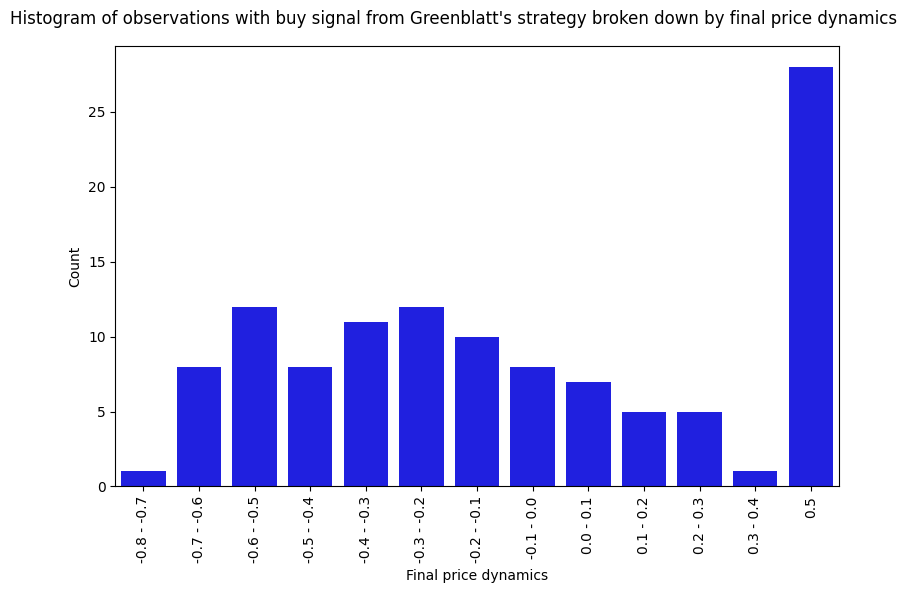

In [228]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        greenblatt_df[greenblatt_df.buy == 'Yes'].final_price_dynamics,
        bins=list(np.linspace(-.8, .5, 14)),
        labels=[f'{round(i, 1)} - {round(i + .1, 1)}' for i in np.linspace(-.8, .3, 12)] + ['0.5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of observations with buy signal from Greenblatt\'s strategy broken down by final price dynamics')

plt.tight_layout();

The Greenblatt's strategy sent buy signal in 59 of the analyzed quarters and was profitable in only 1/3 of them. The strategy outperformed zero effort strategy (i.e. investing in WIG) in 33% of analyzed periods. The Greenblatt's stategy brought the total loss of -866%, while the zero effort strategy was actually profitable (386%). Similarly, the average return on the Greenblatt's stategy is negative (-15%), while for the zero effort strategy it is positive (6%). Moreover, there were 10 quarters, when there were no companies classified as worth buying. In effect, the portfolio reached the minimum size in only 3 quarters.

In [229]:
greenblatt_return_df = pd.DataFrame({
    'Zero effort strategy':dataset.groupby('quarter').final_wig_dynamics.mean(),
    'Greenblatt\'s strategy':greenblatt_df[
        greenblatt_df.buy == 'Yes'
    ].groupby('quarter').final_price_dynamics.sum()
})

greenblatt_portfolio_df = pd.DataFrame({
    'buy_in_q':pd.Series(
        greenblatt_df[
            greenblatt_df.buy == 'Yes'
        ].groupby('quarter').quarter.count().reindex(sorted(dataset.quarter.unique())).fillna(0)
    ),
    'sell_in_q':pd.Series(
        greenblatt_df[
            greenblatt_df.buy == 'Yes'
        ].groupby('sell_in_q').sell_in_q.count().reindex(sorted(dataset.quarter.unique())).fillna(0)
    ),
})
greenblatt_portfolio_df['Greenblatt\'s strategy'] = (
    greenblatt_portfolio_df.buy_in_q - greenblatt_portfolio_df.sell_in_q
).cumsum()
greenblatt_portfolio_df.drop(['buy_in_q', 'sell_in_q'], axis=1, inplace=True)

strategy_stat(dataset, greenblatt_return_df, greenblatt_portfolio_df, 'Greenblatt\'s strategy')

Number of quarters with buy signal from Greenblatt's strategy: 59
Number of quarters with sufficient portfolio size: 3
Number of profitable quarters using Greenblatt's strategy: 23
Number of profitable quarters using zero effort strategy: 43
Number of quarters in which Greenblatt's strategy outperformed zero effort strategy: 23
Total return on Greenblatt's strategy: -866.44%
Total return on zero effort strategy: 386.32%
Average return on Greenblatt's strategy: -14.69%
Average return on zero effort strategy: 5.6%


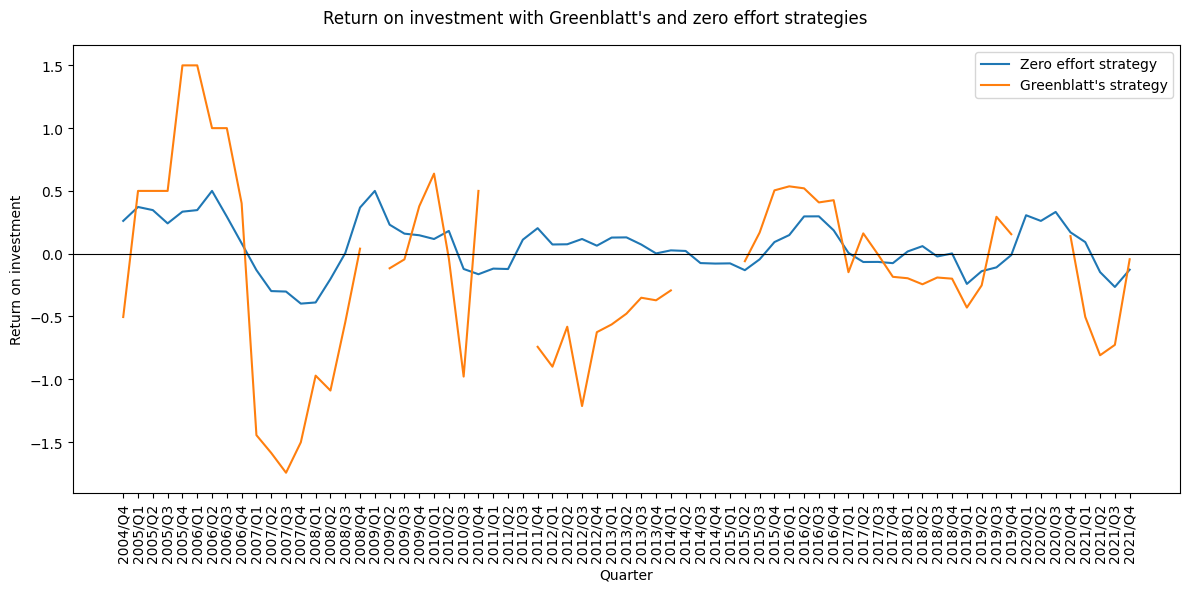

In [230]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(
    greenblatt_return_df.index,
    greenblatt_return_df
)

ax.axhline(0, color='black', linewidth=.8)

ax.tick_params(axis='x', labelrotation=90)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

ax.legend(labels=['Zero effort strategy', 'Greenblatt\'s strategy'])

plt.suptitle('Return on investment with Greenblatt\'s and zero effort strategies')

plt.tight_layout();

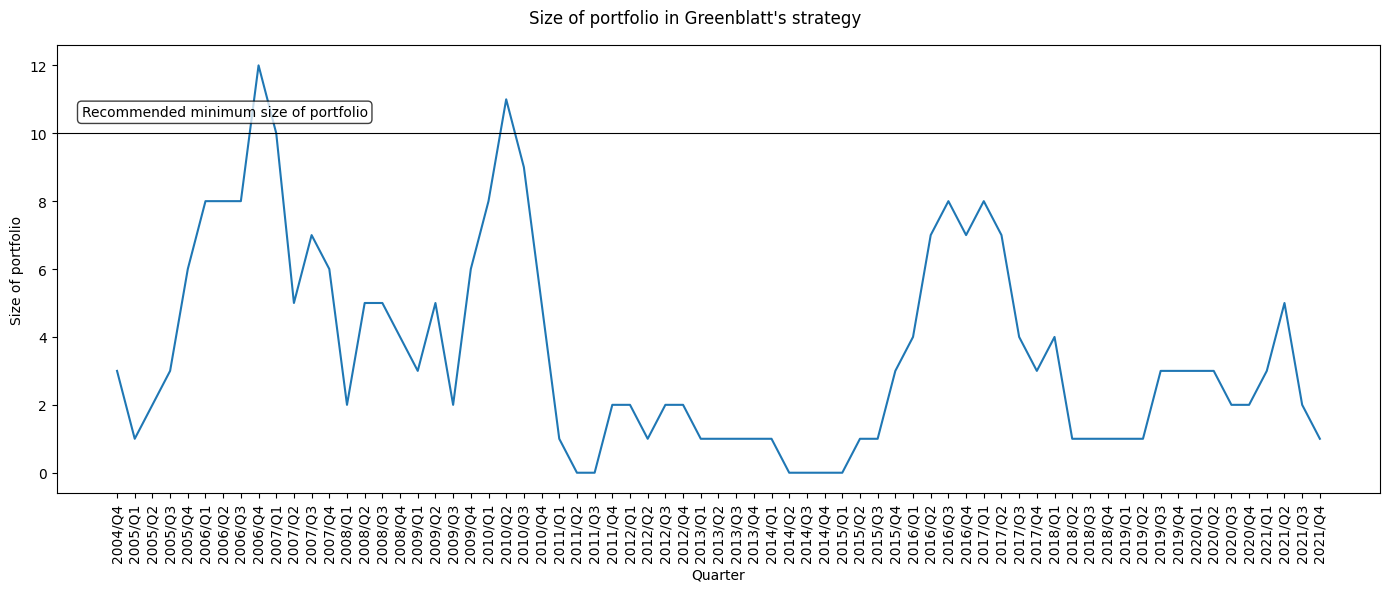

In [231]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=greenblatt_portfolio_df,
    legend=False,
    ax=ax
)

ax.axhline(10, color='black', linewidth=.8)
ax.text(
    -2, 10.5,
    'Recommended minimum size of portfolio',
    color='black',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.75)
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Quarter')
ax.set_ylabel('Size of portfolio')

plt.suptitle('Size of portfolio in Greenblatt\'s strategy')

plt.tight_layout();

The company's capitalization in USD is the first element of Greenblatt's strategy. The range of this feature is from USD 6.3 thousand to USD 75 billion with mean value of USD 411 million, though the median is USD 40 million. Almost 55% of observations fall below the strategy treshold of USD 50 million.

In [232]:
print('The basic statistics of capitalization in USD in Greenblatt\'s strategy:')
print(greenblatt_df.capitalization_usd.describe())
print('\nCapitalization in USD million in Greenblatt\'s strategy:')
print(pd.Series(np.where(
    greenblatt_df.capitalization_usd > 5e7,
    'Over USD 50 million', 'Below USD 50 million'
)).value_counts())

The basic statistics of capitalization in USD in Greenblatt's strategy:
count         17502.00
mean      411159659.15
std      1810736342.43
min            6306.89
25%        13762277.91
50%        39686310.66
75%       149677218.43
max     74944024919.08
Name: capitalization_usd, dtype: float64

Capitalization in USD million in Greenblatt's strategy:
Below USD 50 million    9648
Over USD 50 million     7854
dtype: int64


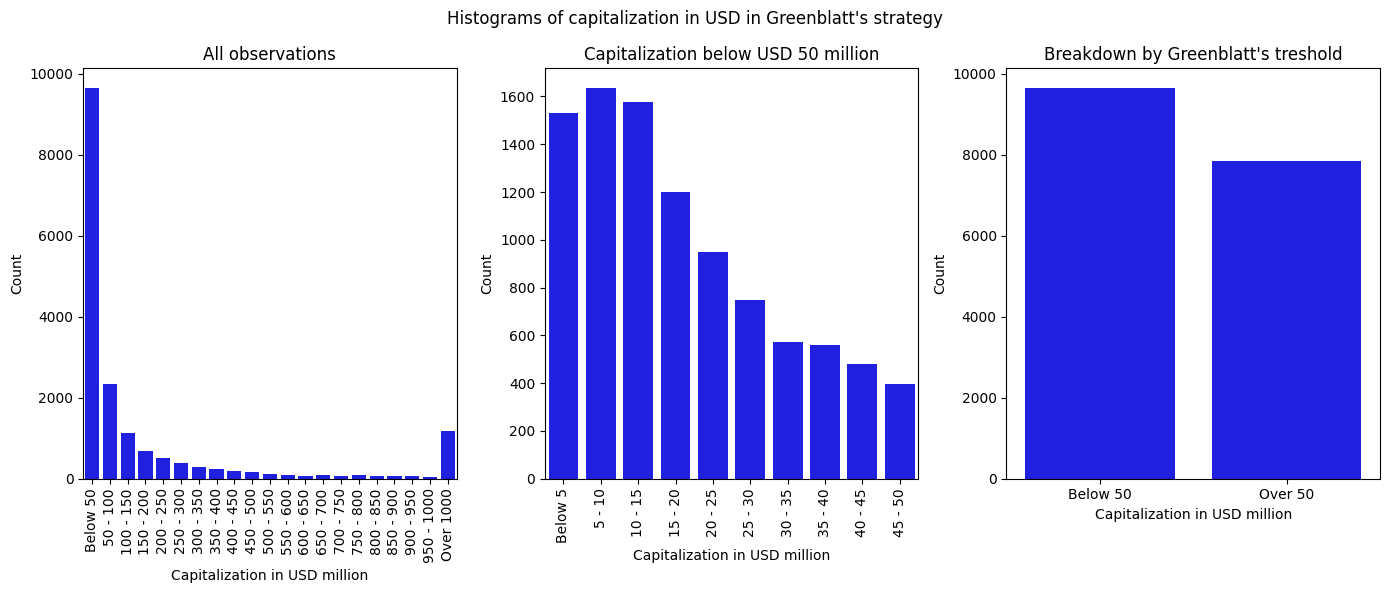

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.countplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=list(np.arange(0, 10.5e8, 5e7)) + [7.5e10],
        labels=['Below 50'] + [f'{i} - {i+50}' for i in range(50, 1000, 50)] + ['Over 1000']
    ),
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.cut(
        greenblatt_df[greenblatt_df.capitalization_usd < 5e7].capitalization_usd,
        bins=list(np.arange(0, 5.5e7, 5e6)),
        labels=['Below 5'] + [f'{i} - {i+5}' for i in range(5, 50, 5)]
    ),
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=[0, 5e7, 7.5e10],
        labels=['Below 50', 'Over 50']
    ),
    color='blue',
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Capitalization in USD million')
    axs[i].set_ylabel('Count')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Histograms of capitalization in USD in Greenblatt\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Capitalization below USD 50 million')
axs[2].set_title('Breakdown by Greenblatt\'s treshold')

plt.tight_layout();

The boxplots below indicate, that Greenblatt's treshold for capitalization in USD is not proper for analyzed dataset. The median final price dynamics is actually higher for companies with capitalization below USD 50 million then the rest (and even higher for companies with capitalization below USD 15 million). Moreover, there are number of intervals which should minimize losses a bit, i.e. have either minimum value or 75th percentile closer to 0 - however, all intervals contain some observations with negative final price dynamics.

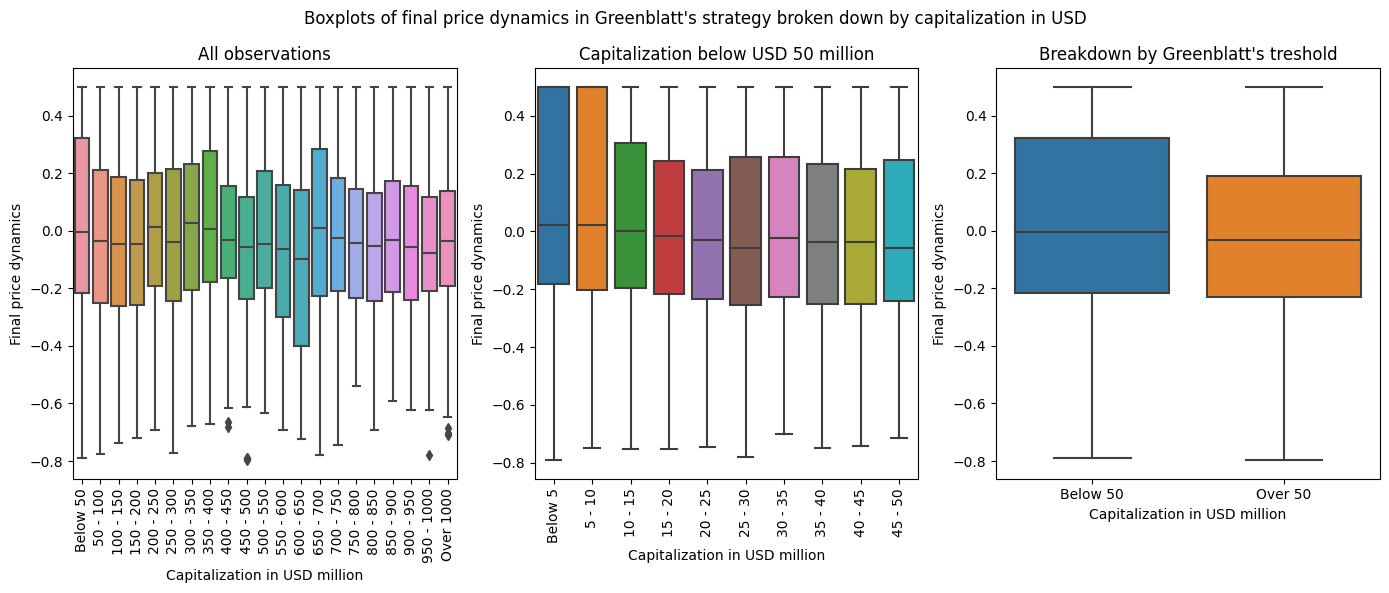

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=list(np.arange(0, 10.5e8, 5e7)) + [7.5e10],
        labels=['Below 50'] + [f'{i} - {i+50}' for i in range(50, 1000, 50)] + ['Over 1000']
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df[greenblatt_df.capitalization_usd < 5e7].capitalization_usd,
        bins=list(np.arange(0, 5.5e7, 5e6)),
        labels=['Below 5'] + [f'{i} - {i+5}' for i in range(5, 50, 5)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[1]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df.capitalization_usd,
        bins=[0, 5e7, 7.5e10],
        labels=['Below 50', 'Over 50']
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Capitalization in USD million')
    axs[i].set_ylabel('Final price dynamics')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Boxplots of final price dynamics in Greenblatt\'s strategy broken down by capitalization in USD')
axs[0].set_title('All observations')
axs[1].set_title('Capitalization below USD 50 million')
axs[2].set_title('Breakdown by Greenblatt\'s treshold')

plt.tight_layout();

Looking at proportion of interesting investments confirms that companies with capitalization below USD 50 million gave greater chance of return of investment of at least 50%. Especially observations with capitalization below USD 15 million - or even 5 million - are promising. Similarly, observations with capitalization below USD 10 million provides the lowest risk of loss.

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.capitalization_usd,
            bins=list(np.arange(0, 10.5e8, 5e7)) + [7.5e10],
            labels=['Below 50'] + [f'{i} - {i+50}' for i in range(50, 1000, 50)] + ['Over 1000']
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df[greenblatt_df.capitalization_usd < 5e7].capitalization_usd,
            bins=list(np.arange(0, 5.5e7, 5e6)),
            labels=['Below 5'] + [f'{i} - {i+5}' for i in range(5, 50, 5)]
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.capitalization_usd,
            bins=[0, 5e7, 7.5e10],
            labels=['Below 50', 'Over 50']
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='y', labelrotation=0)
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Capitalization in USD million')
axs[2].tick_params(axis='y', labelrotation=90)

plt.suptitle('Interesting investments broken down by capitalization in USD')
axs[0].set_title('All observations')
axs[1].set_title('Capitalization below USD 50 million')
axs[2].set_title('Breakdown by Greenblatt\'s treshold')

plt.tight_layout();

The position in Greenblatt's ranking is a very limiting variable - only 663 observations (less than 4% of whole subdataset) passed this constraint. This feature represents an average position in EV/EBIT ranking (the lower value of EV/EBIT the better, excluding negative values) and ROIC ranking (the higher value of ROIC the better), so we have to look also at these features to understand influence of Greenblatt's ranking.

In [24]:
print('Greenblatt\'s ranking:')
print(pd.Series(np.where(
    greenblatt_df.greenblatt_rank <= 10,
    'Below 11th position', 'Over 10th position'
)).value_counts())

Greenblatt's ranking:
Over 10th position     16858
Below 11th position      663
dtype: int64


As we can see in the boxplots below, the median and 75th percentile of final price dynamics grow slowly with lower position in Greenblatt's ranking. Simultaneously, in EV/EBIT and ROIC rankings the 2nd and 3rd quartiles decrease with lower position. This situation occurs because of construction of Greenblatt's ranking - it takes not only observations with top position in each ranking, but also those, which have good EV/EBIT value and worse ROIC value (or vice versa). In the result, the mediocre observations are taken into consideration.

Suprisingly, there are intervals at the end of EV/EBIT and ROIC rankings, which have similar interquartile range to those from the top. Similarly, the proportion of interesting investments are the highest for tops and bottoms of both rankings. In both cases there are negative values at the end of each ranking (i.e. EV/EBIT ranking is ascending, but negative values are moved to the end, ROIC ranking is descending, so negative values would be always at the end), so it may be a good idea to look at EV/EBIT and ROIC directly.

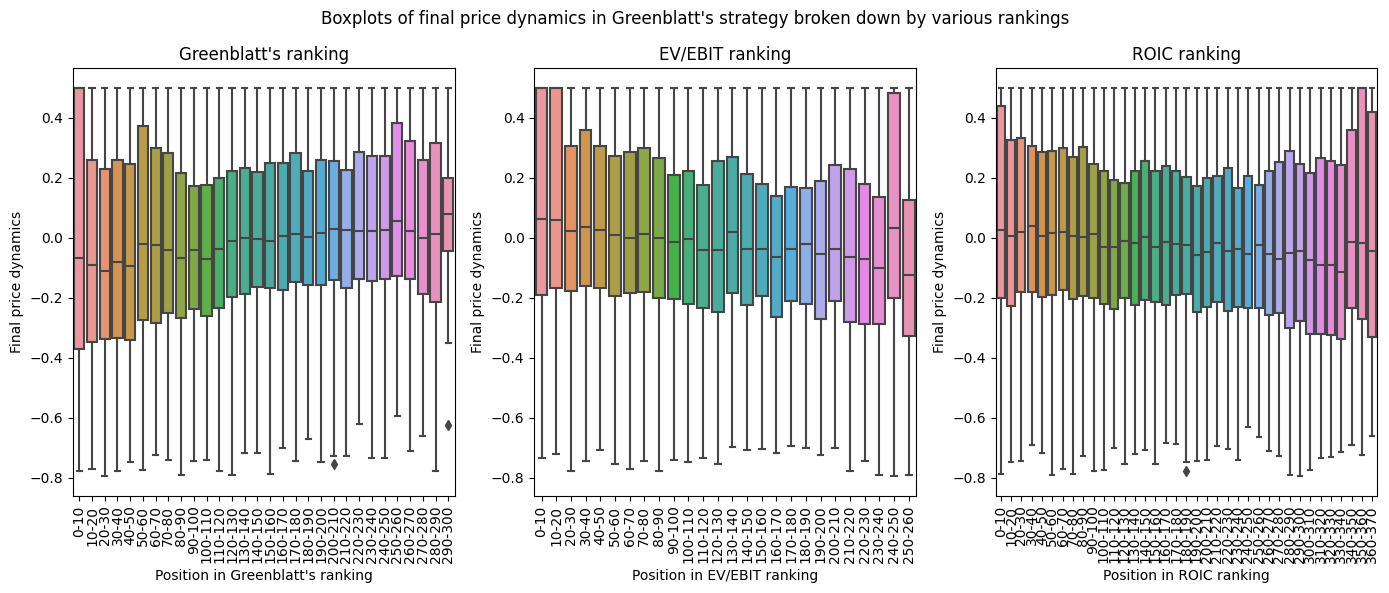

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        greenblatt_df.greenblatt_rank,
        bins=range(0, 310, 10),
        labels=[f'{i} - {i+10}' for i in range(0, 300, 10)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df.rank_ev_ebit,
        bins=range(0, 270, 10),
        labels=[f'{i} - {i+10}' for i in range(0, 260, 10)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[1]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df.rank_roic,
        bins=range(0, 380, 10),
        labels=[f'{i} - {i+10}' for i in range(0, 370, 10)]
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_ylabel('Final price dynamics')

axs[0].set_xlabel('Position in Greenblatt\'s ranking')
axs[1].set_xlabel('Position in EV/EBIT ranking')
axs[2].set_xlabel('Position in ROIC ranking')

plt.suptitle('Boxplots of final price dynamics in Greenblatt\'s strategy broken down by various rankings')
axs[0].set_title('Greenblatt\'s ranking')
axs[1].set_title('EV/EBIT ranking')
axs[2].set_title('ROIC ranking')

plt.tight_layout();

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.greenblatt_rank,
            bins=range(0, 310, 10),
            labels=[f'{i} - {i+10}' for i in range(0, 300, 10)]
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.rank_ev_ebit,
            bins=range(0, 270, 10),
            labels=[f'{i} - {i+10}' for i in range(0, 260, 10)]
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.rank_roic,
            bins=range(0, 380, 10),
            labels=[f'{i} - {i+10}' for i in range(0, 370, 10)]
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='y', labelrotation=0)
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Position in ranking')

plt.suptitle('Interesting investments broken down by rankings')
axs[0].set_title('Greenblatt\'s ranking')
axs[1].set_title('EV/EBIT ranking')
axs[2].set_title('ROIC ranking')

plt.tight_layout();

About 1/5 of EV/EBIT values are negative and putting them at the bottom of EV/EBIT ranking may improve performance of observations with low ranking position. However, as this feature's boxplot suggests, the best values of EV/EBIT are in the interval of 0 - 4 (or, more conservatively, 0 - 2). These intervals provide also the highest chance of return on investment greater than 50%, as well as the lowest risk of making a loss.

In case of ROIC, the negative values may have better performance than some of positive intervals. However, the best chance of hitting interesting investment - and the lowest risk of making a loss - provides ROIC over 0.5. Such values represent less than 5% of the analyzed dataset.

In [28]:

print('The basic statistics of EV/EBIT and ROIC in Greenblatt\'s strategy:')
greenblatt_df[['ev_ebit', 'roic']].describe()

The basic statistics of EV/EBIT and ROIC in Greenblatt's strategy:


ev_ebit     roic
count  17521.00 17521.00
mean      28.53     0.00
std     1867.93     7.74
min   -56395.54  -713.13
25%        3.20     0.02
50%        9.02     0.09
75%       15.68     0.17
max   180275.63   232.49

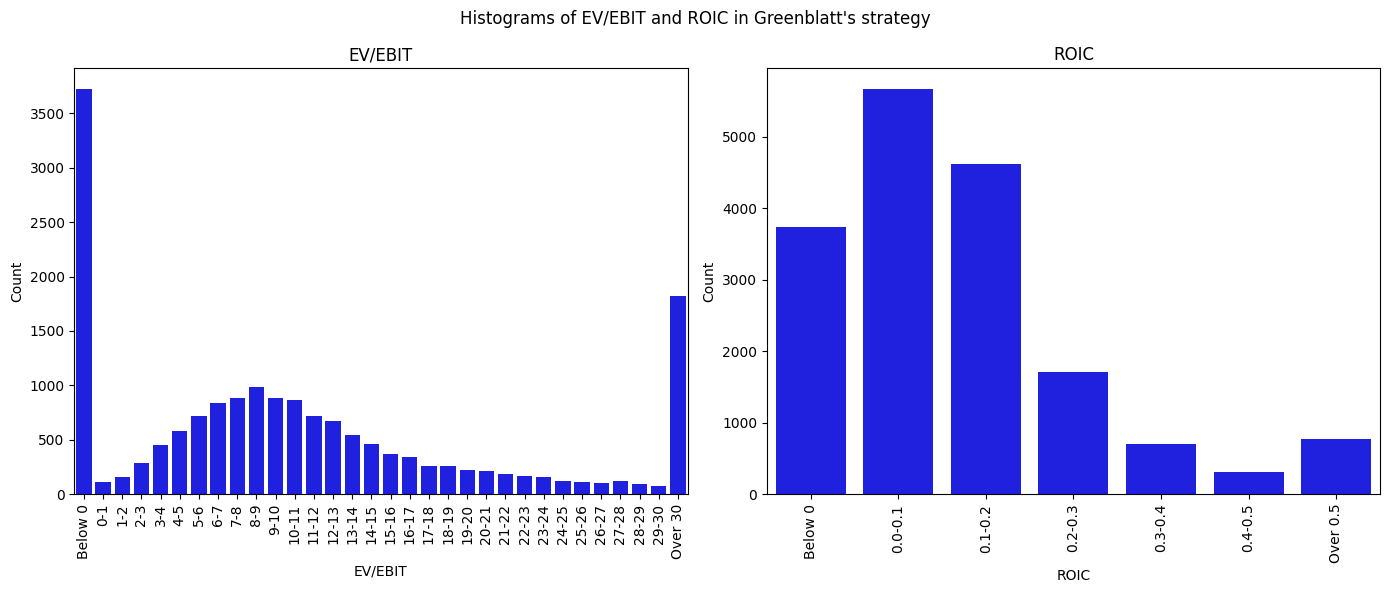

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(
    x=pd.cut(
        greenblatt_df.ev_ebit,
        bins=[-1e4] + list(range(0, 31)) + [2e4],
        labels=['Below 0'] + [f'{i} - {i+1}' for i in range(0, 30)] + ['Over 30']
    ),
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.cut(
        greenblatt_df.roic,
        bins=[-1e4] + list(np.arange(0, .6, .1)) + [2e4],
        labels=['Below 0'] + [f'{round(i, 1)} - {round(i+.1, 1)}' for i in np.arange(0, .5, .1)] + ['Over 0.5']
    ),
    color='blue',
    ax=axs[1]
)

for i in range(2):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_ylabel('Count')

axs[0].set_xlabel('EV/EBIT')
axs[1].set_xlabel('ROIC')

plt.suptitle('Histograms of EV/EBIT and ROIC in Greenblatt\'s strategy')
axs[0].set_title('EV/EBIT')
axs[1].set_title('ROIC')

plt.tight_layout();

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        greenblatt_df.ev_ebit,
        bins=[-1e4] + list(range(0, 31)) + [2e4],
        labels=['Below 0'] + [f'{i} - {i+1}' for i in range(0, 30)] + ['Over 30']
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        greenblatt_df.roic,
        bins=[-1e4] + list(np.arange(0, .6, .1)) + [2e4],
        labels=['Below 0'] + [f'{round(i, 1)} - {round(i+.1, 1)}' for i in np.arange(0, .5, .1)] + ['Over 0.5']
    ),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[1]
)

for i in range(2):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_ylabel('Final price dynamics')
    
axs[0].set_xlabel('EV/EBIT')
axs[1].set_xlabel('ROIC')

plt.suptitle('Boxplots of final price dynamics in Greenblatt\'s strategy broken down by EV/EBIT and ROIC')
axs[0].set_title('EV/EBIT')
axs[1].set_title('ROIC')

plt.tight_layout();

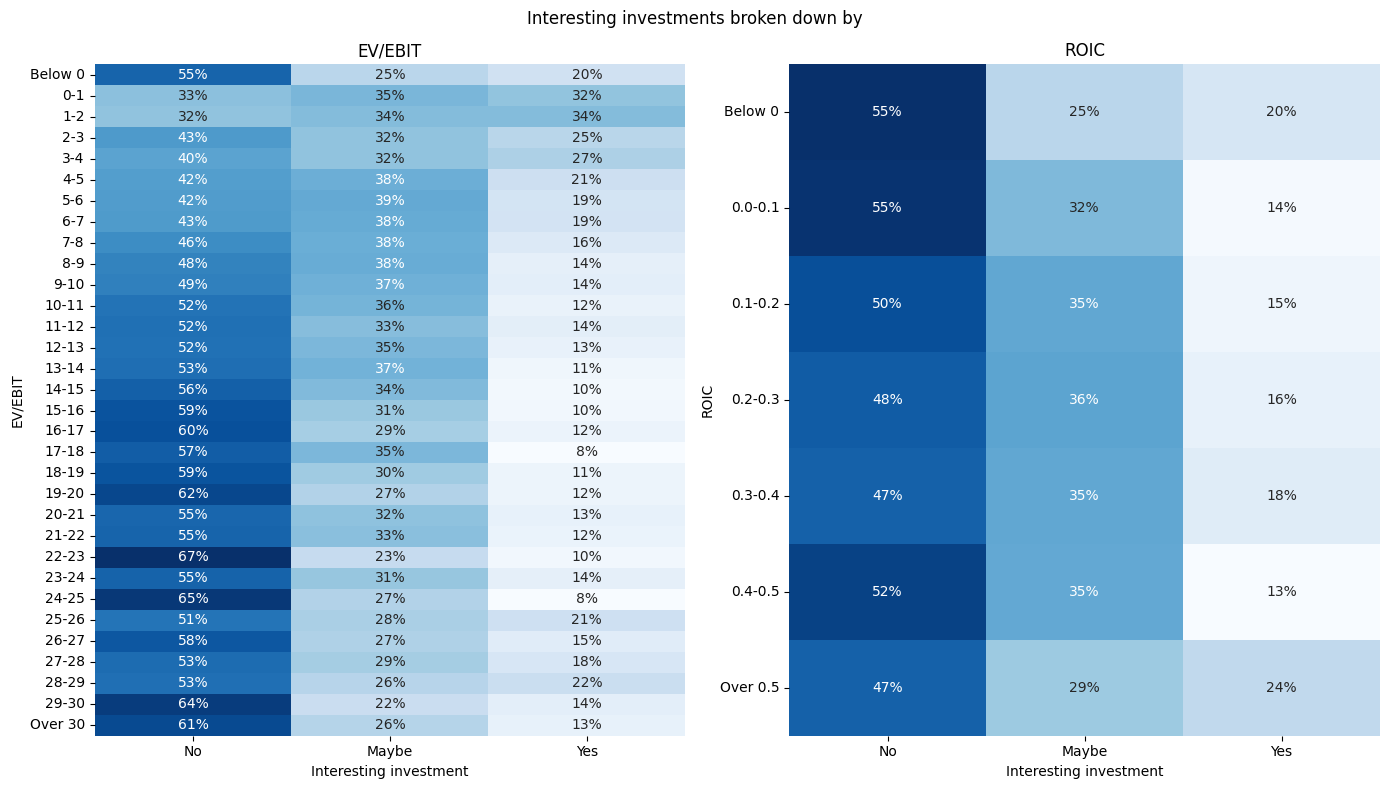

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.ev_ebit,
            bins=[-1e4] + list(range(0, 31)) + [2e4],
            labels=['Below 0'] + [f'{i} - {i+1}' for i in range(0, 30)] + ['Over 30']
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            greenblatt_df.roic,
            bins=[-1e4] + list(np.arange(0, .6, .1)) + [2e4],
            labels=['Below 0'] + [f'{round(i, 1)} - {round(i+.1, 1)}' for i in np.arange(0, .5, .1)] + ['Over 0.5']
        ),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

for i in range(2):
    axs[i].tick_params(axis='y', labelrotation=0)
    axs[i].set_xlabel('Interesting investment')

axs[0].set_ylabel('EV/EBIT')
axs[1].set_ylabel('ROIC')

plt.suptitle('Interesting investments broken down by')
axs[0].set_title('EV/EBIT')
axs[1].set_title('ROIC')

plt.tight_layout();

The vast majority of observations concerned Polish companies (more than 90%). Among foreign companies, those from Luxembourg and the Netherlands prevailed. Home companies are comparable with average foreign company, though there are some companies from countries like Spain or Bulgaria, which performs better than Polish. It may be a good idea to use all countries to increase the number of observations with a buy signal.

In [31]:
print('Companies in Greenblatt\'s strategy:')
print(pd.Series(np.where(
    greenblatt_df.country == 'PL',
    'Home', 'Foreign'
)).value_counts())

Companies in Greenblatt's strategy:
Home       16335
Foreign     1186
dtype: int64


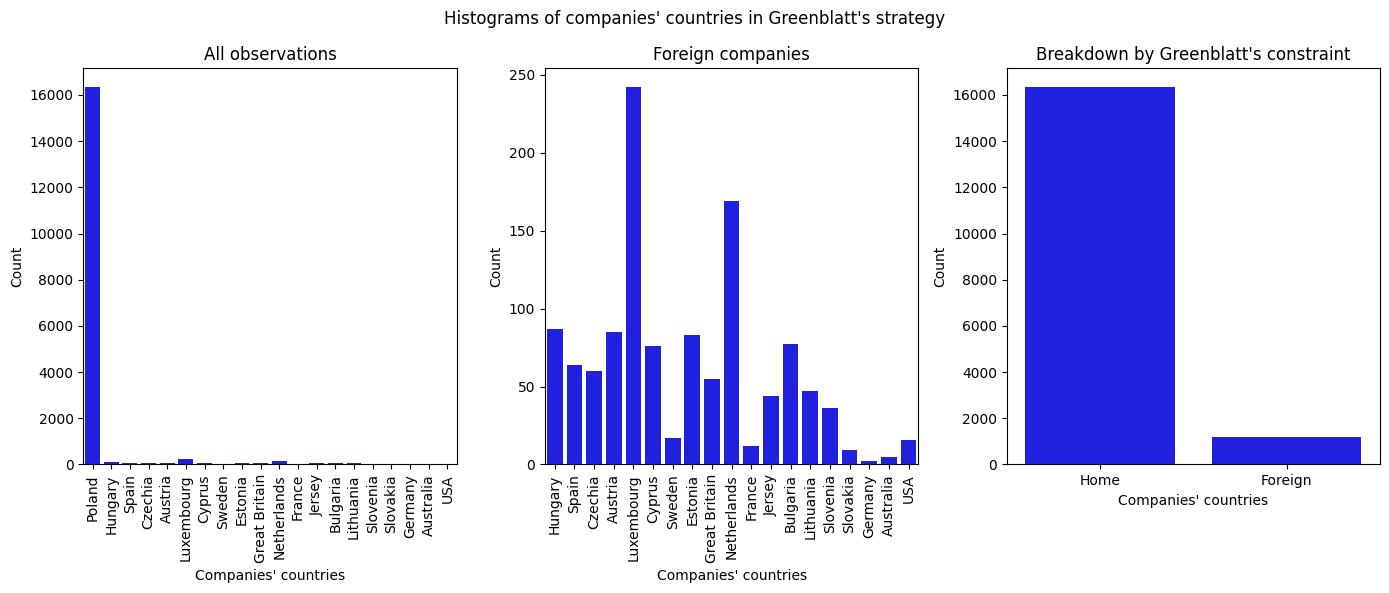

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.countplot(
    x=greenblatt_df.country,
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=greenblatt_df[greenblatt_df.country != 'PL'].country,
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.Series(np.where(
        greenblatt_df.country == 'PL',
        'Home', 'Foreign'
    )),
    color='blue',
    ax=axs[2]
)

axs[0].set_xticklabels([
    'Poland', 'Hungary', 'Spain', 'Czechia', 'Austria', 'Luxembourg', 'Cyprus',
    'Sweden', 'Estonia', 'Great Britain', 'Netherlands', 'France', 'Jersey',
    'Bulgaria', 'Lithuania', 'Slovenia', 'Slovakia', 'Germany', 'Australia', 'USA'
])

axs[1].set_xticklabels([
    'Hungary', 'Spain', 'Czechia', 'Austria', 'Luxembourg', 'Cyprus', 'Sweden',
    'Estonia', 'Great Britain', 'Netherlands', 'France', 'Jersey', 'Bulgaria',
    'Lithuania', 'Slovenia', 'Slovakia', 'Germany', 'Australia', 'USA'
])

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Companies\' countries')
    axs[i].set_ylabel('Count')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Histograms of companies\' countries in Greenblatt\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Foreign companies')
axs[2].set_title('Breakdown by Greenblatt\'s constraint')

plt.tight_layout();

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
    x=greenblatt_df.country,
    y=greenblatt_df.final_price_dynamics,
    ax=axs[0]
)
sns.boxplot(
    x=pd.Series(np.where(
        greenblatt_df.country == 'PL',
        'Home', 'Foreign'
    )),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[1]
)

axs[0].set_xticklabels([
    'Poland', 'Hungary', 'Spain', 'Czechia', 'Austria', 'Luxembourg', 'Cyprus',
    'Sweden', 'Estonia', 'Great Britain', 'Netherlands', 'France', 'Jersey',
    'Bulgaria', 'Lithuania', 'Slovenia', 'Slovakia', 'Germany', 'Australia', 'USA'
])

for i in range(2):
    axs[i].set_xlabel('Companies\' countries')
    axs[i].set_ylabel('Final price dynamics')
axs[0].tick_params(axis='x', labelrotation=90)

plt.suptitle('Boxplots of final price dynamics in Greenblatt\'s strategy broken down by companies\' countries')
axs[0].set_title('Breakdown by countries')
axs[1].set_title('Breakdown by Greenblatt\'s constraint')

plt.tight_layout();

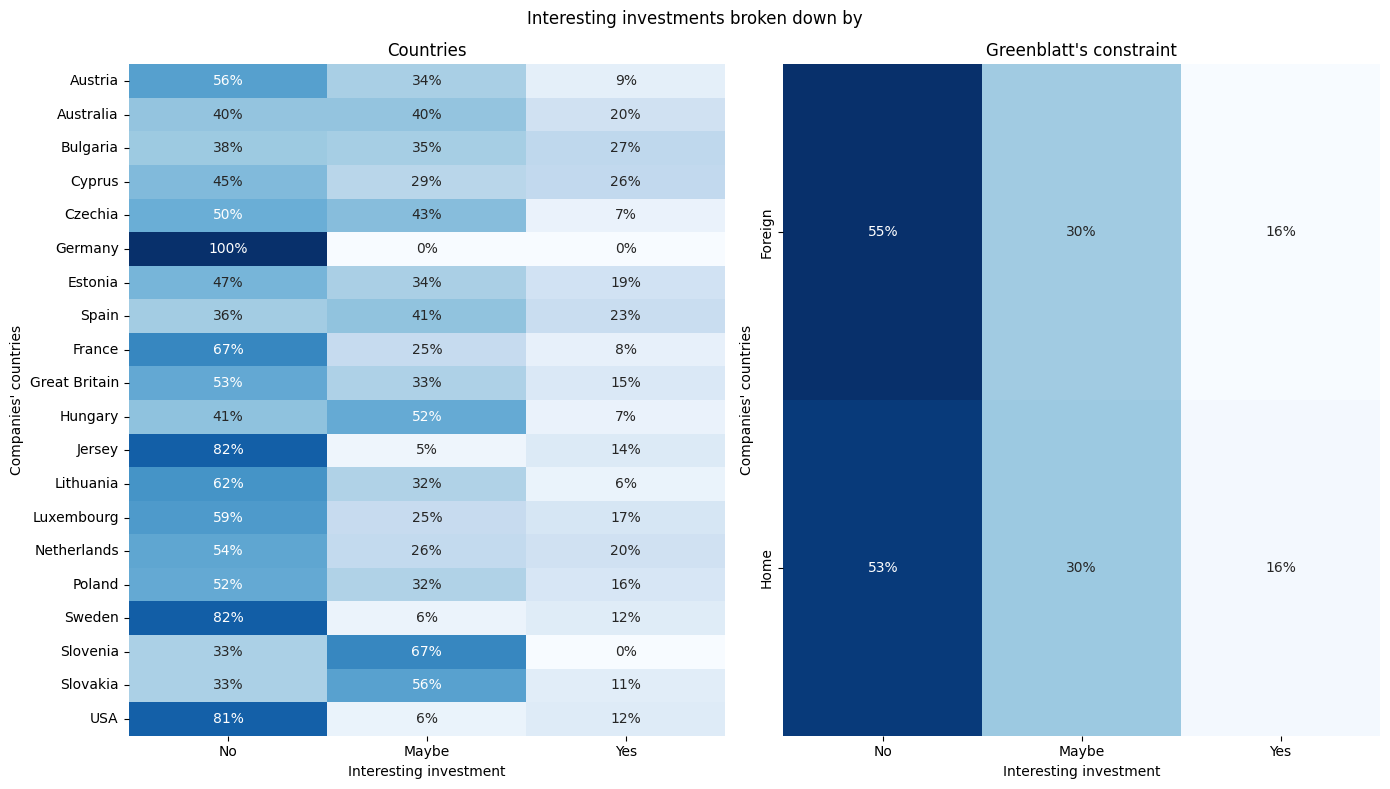

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

custom_heatmap(
    pd.crosstab(
        greenblatt_df.country,
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            greenblatt_df.country == 'PL',
            'Home', 'Foreign'
        )),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

axs[0].set_yticklabels([
    'Austria', 'Australia', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany',
    'Estonia', 'Spain', 'France', 'Great Britain', 'Hungary', 'Jersey',
    'Lithuania', 'Luxembourg', 'Netherlands', 'Poland', 'Sweden',    
    'Slovenia', 'Slovakia', 'USA'
])

for i in range(2):
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Companies\' countries')
axs[0].tick_params(axis='y', labelrotation=0)

plt.suptitle('Interesting investments broken down by')
axs[0].set_title('Countries')
axs[1].set_title('Greenblatt\'s constraint')

plt.tight_layout();

The case of industries is similar to countries - there is only small difference between average included and excluded observations. Similarly, we may use all industries to increase number of available observations.

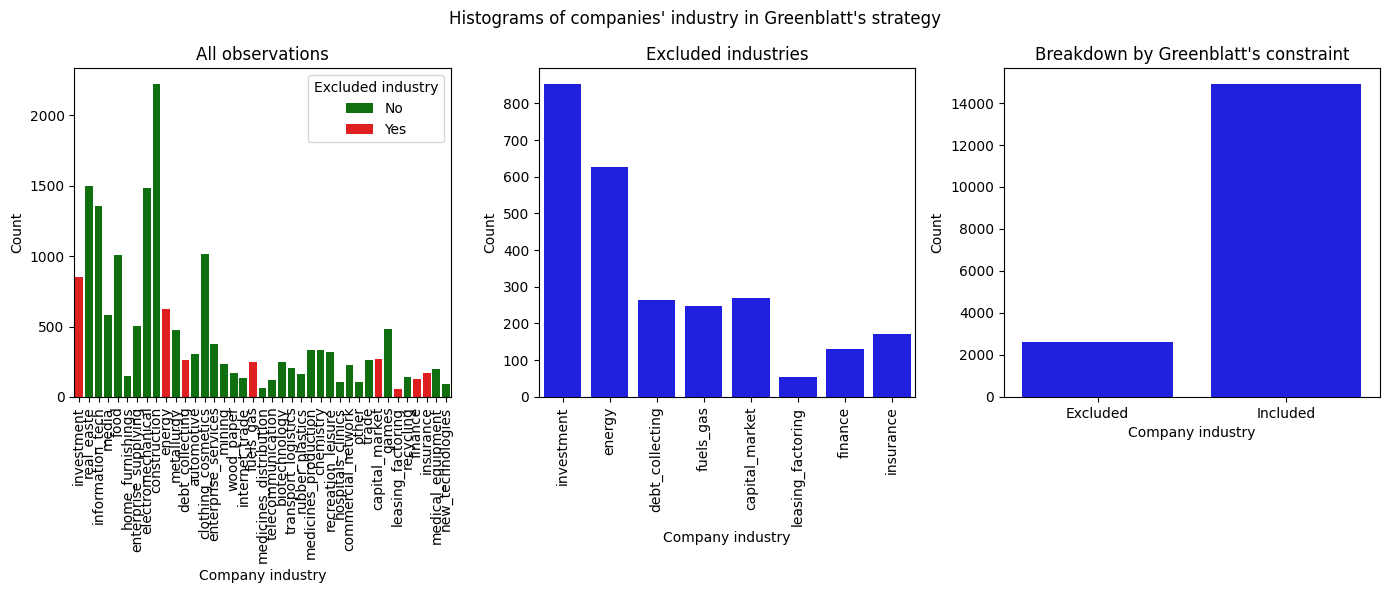

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.countplot(
    x=greenblatt_df.industry,
    hue=greenblatt_df.industry.isin(forbidden_industry),
    palette=['green', 'red'],
    dodge=False,
    ax=axs[0]
)

sns.countplot(
    x=greenblatt_df[greenblatt_df.industry.isin(forbidden_industry)].industry,
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.Series(np.where(
        greenblatt_df.industry.isin(forbidden_industry),
        'Excluded', 'Included'
    )),
    color='blue',
    ax=axs[2]
)

axs[0].legend(title='Excluded industry', labels=['No', 'Yes'])

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Company industry')
    axs[i].set_ylabel('Count')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Histograms of companies\' industry in Greenblatt\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Excluded industries')
axs[2].set_title('Breakdown by Greenblatt\'s constraint')

plt.tight_layout();

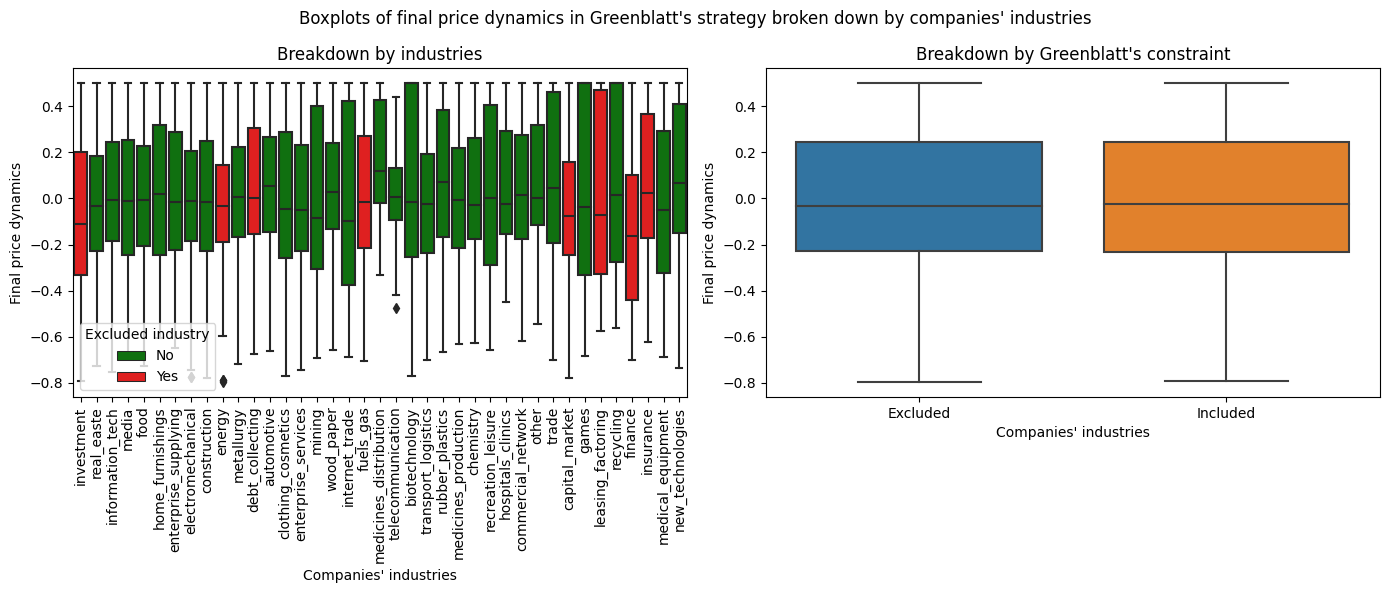

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
    x=greenblatt_df.industry,
    y=greenblatt_df.final_price_dynamics,
    hue=greenblatt_df.industry.isin(forbidden_industry),
    palette=['green', 'red'],
    dodge=False,
    ax=axs[0]
)
sns.boxplot(
    x=pd.Series(np.where(
        greenblatt_df.industry.isin(forbidden_industry),
        'Excluded', 'Included'
    )),
    y=greenblatt_df.final_price_dynamics,
    ax=axs[1]
)

axs[0].legend(title='Excluded industry', labels=['No', 'Yes'], loc='lower left')

for i in range(2):
    axs[i].set_xlabel('Companies\' industries')
    axs[i].set_ylabel('Final price dynamics')
axs[0].tick_params(axis='x', labelrotation=90)

plt.suptitle('Boxplots of final price dynamics in Greenblatt\'s strategy broken down by companies\' industries')
axs[0].set_title('Breakdown by industries')
axs[1].set_title('Breakdown by Greenblatt\'s constraint')

plt.tight_layout();

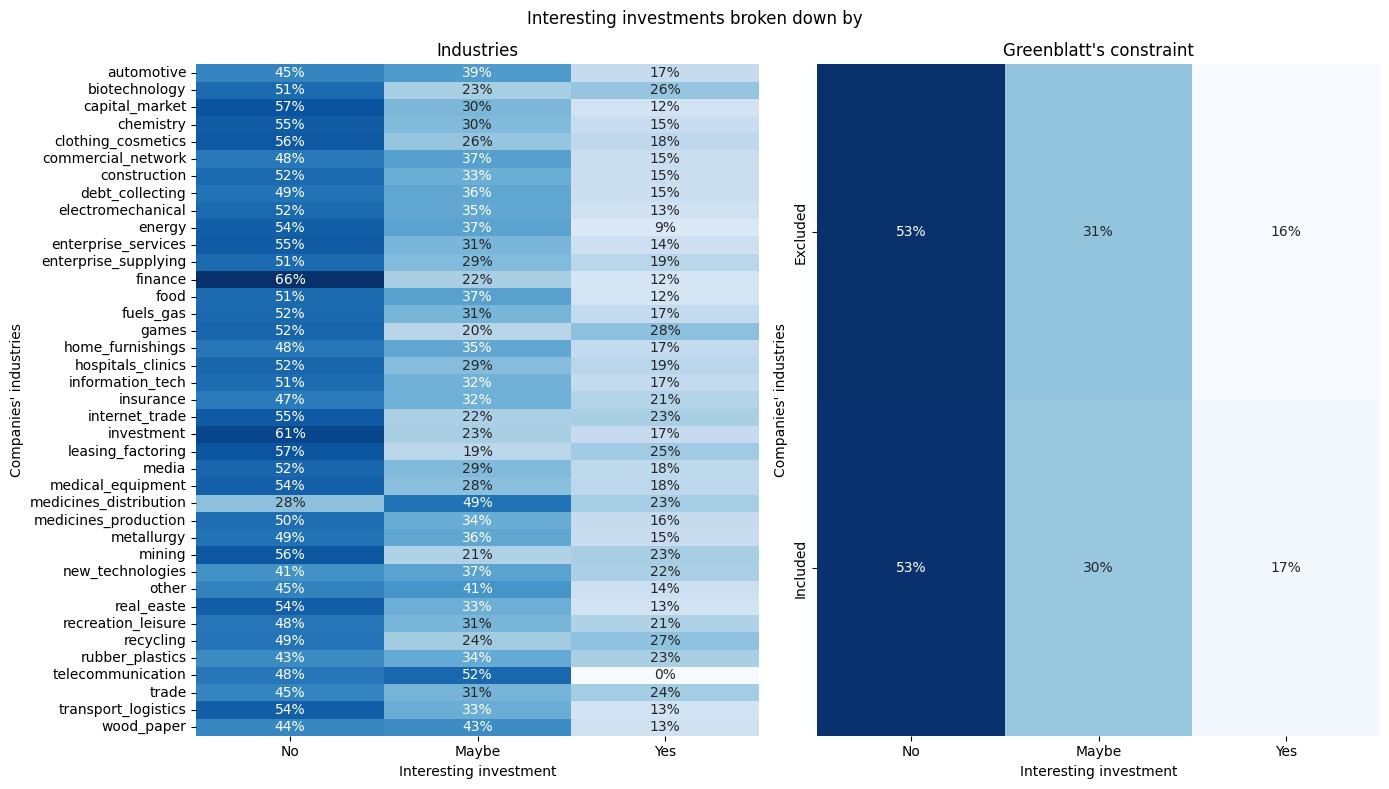

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

custom_heatmap(
    pd.crosstab(
        greenblatt_df.industry,
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            greenblatt_df.industry.isin(forbidden_industry),
            'Excluded', 'Included'
        )),
        greenblatt_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

for i in range(2):
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Companies\' industries')

plt.suptitle('Interesting investments broken down by')
axs[0].set_title('Industries')
axs[1].set_title('Greenblatt\'s constraint')

plt.tight_layout();

By adopting the above assumptions regarding the indicators proposed by Greenblatt, we can check what value ranges we should adopt for each variable. The general assumption is that the strategies should bring positive total and average profits and meet the requirement of minimum portfolio filling (i.e. at least 10 companies in each quarter) in at least 80% of the analyzed period (i.e. in at least 55 quarters). The observations had to have capitalization below USD 50 million, EV/EBIT between 0 and 4, as well as ROIC over 0. As we can see below, the adoption of these boundary conditions provided the best results.

In [239]:
greenblatt_mod_df = {
    'Capitalization in USD below:':[],
    'EV/EBIT below:':[],
    'ROIC over:':[],
    'Total return (%)':[],
    'Average return (%)':[],
    'Number of quarters with portfolio size over 10':[],
    'Number of profitable quarters':[],
    'Number of quarters in which strategy outperformed zero effort strategy':[],
    'Percentage of profitable investments':[],
    'Percentage of loss-making investments':[]
}


for mod_1 in np.arange(5e6, 5.5e7, 5e6): # Capitalization in million USD 
    for mod_2 in np.arange(0.1, 4.1, .1): # EV/EBIT
        for mod_3 in np.arange(.5, -.05, -.05): # ROIC
            greenblatt_df['mod_buy'] = np.where(
                (greenblatt_df.capitalization_usd < mod_1) &
                (greenblatt_df.ev_ebit > 0) &
                (greenblatt_df.ev_ebit < mod_2) &
                (greenblatt_df.roic > mod_3),
                'Yes', 'No'
            )

            # Return on Modified Greenblatt\'s strategy
            greenblatt_return_df['Modified Greenblatt\'s strategy'] = greenblatt_df[
                greenblatt_df.mod_buy == 'Yes'
            ].groupby('quarter').final_price_dynamics.sum()

            strategy_return = (
                100 * greenblatt_return_df['Modified Greenblatt\'s strategy'].sum()
            ).round(2)
            avg_strategy_return = (
                100 * greenblatt_return_df['Modified Greenblatt\'s strategy'].mean()
            ).round(2)

            # If positive
            if strategy_return > 0 and avg_strategy_return > 0:

                # Size of portfolio in Modified Greenblatt\'s strategy
                greenblatt_portfolio_df['buy_in_q'] = pd.Series(
                    greenblatt_df[
                        greenblatt_df.mod_buy == 'Yes'
                    ].groupby('quarter').quarter.count().reindex(sorted(dataset.quarter.unique())).fillna(0)
                )
                greenblatt_portfolio_df['sell_in_q'] = pd.Series(
                    greenblatt_df[
                        greenblatt_df.mod_buy == 'Yes'
                    ].groupby('sell_in_q').sell_in_q.count().reindex(sorted(dataset.quarter.unique())).fillna(0)
                )

                greenblatt_portfolio_df['Modified Greenblatt\'s strategy'] = (
                    greenblatt_portfolio_df.buy_in_q - greenblatt_portfolio_df.sell_in_q
                ).cumsum()
                greenblatt_portfolio_df.drop(['buy_in_q', 'sell_in_q'], axis=1, inplace=True)

                quarters_with_good_portfolio_size = greenblatt_portfolio_df[
                    greenblatt_portfolio_df['Modified Greenblatt\'s strategy'] >= 10
                ]['Modified Greenblatt\'s strategy'].count()

                # If number of quarters with good portfolio size >= 55 (80% of all quarters)
                if quarters_with_good_portfolio_size > 55:

                    # Profitable quarters
                    quarters_profit_strat = greenblatt_return_df[
                        greenblatt_return_df['Modified Greenblatt\'s strategy'] > 0
                    ]['Modified Greenblatt\'s strategy'].count()

                    # Strategy > zero effort strategy
                    quarters_perform_strat = greenblatt_return_df[
                        greenblatt_return_df['Modified Greenblatt\'s strategy'] > greenblatt_return_df['Zero effort strategy']
                    ]['Modified Greenblatt\'s strategy'].count()

                    greenblatt_mod_df['Capitalization in USD below:'].append(mod_1)
                    greenblatt_mod_df['EV/EBIT below:'].append(mod_2)
                    greenblatt_mod_df['ROIC over:'].append(mod_3)
                    greenblatt_mod_df['Total return (%)'].append(strategy_return)
                    greenblatt_mod_df['Average return (%)'].append(avg_strategy_return)
                    greenblatt_mod_df['Number of quarters with portfolio size over 10'].append(quarters_with_good_portfolio_size)
                    greenblatt_mod_df['Number of profitable quarters'].append(quarters_profit_strat)
                    greenblatt_mod_df['Number of quarters in which strategy outperformed zero effort strategy'].append(quarters_perform_strat)

                    # Number of signals
                    signals = greenblatt_df.mod_buy.value_counts()[1]

                    # Crosstab
                    ctab = pd.crosstab(
                        greenblatt_df.interesting_investment,
                        greenblatt_df.mod_buy, 
                        rownames=['Interesting investment:'],
                        colnames=['Buy signal from modified Greenblatt\'s strategy:']
                    ).reindex(['No', 'Maybe', 'Yes'], axis=0)

                    # % of interesting_investment == Maybe or Yes
                    greenblatt_mod_df['Percentage of profitable investments'].append(round(100 * (ctab.iloc[1, 1] + ctab.iloc[2, 1]) / signals))
                    # % of interesting_investment == No
                    greenblatt_mod_df['Percentage of loss-making investments'].append(round(100 * ctab.iloc[0, 1] / signals))

greenblatt_mod_df = pd.DataFrame(greenblatt_mod_df)

print('Data frame with best modifications of Greenblatt\'s strategy:')
greenblatt_mod_df

Data frame with best modifications of Greenblatt's strategy:


Capitalization in USD below:  EV/EBIT below:  ROIC over:  Total return (%)  \
0                   45000000.00            4.00        0.10           7850.20   
1                   45000000.00            4.00        0.05           8430.12   
2                   45000000.00            4.00        0.00           8671.24   
3                   50000000.00            3.80        0.05           8355.86   
4                   50000000.00            3.80        0.00           8564.10   
5                   50000000.00            3.90        0.05           8719.10   
6                   50000000.00            3.90        0.00           8927.34   
7                   50000000.00            4.00        0.10           8439.17   
8                   50000000.00            4.00        0.05           9019.09   
9                   50000000.00            4.00        0.00           9260.21   

   Average return (%)  Number of quarters with portfolio size over 10  \
0              126.62                                              56   
1              133.81                                              57   
2              137.64                                              57   
3              134.77                                              57   
4              138.13                                              57   
5              138.40                                              57   
6              141.70                                              57   
7              136.12                                              58   
8              143.16                                              59   
9              146.99                                              59   

   Number of profitable quarters  \
0                             40   
1                             41   
2                             41   
3                             39   
4                             39   
5                             40   
6                             40   
7                             40   
8                             40   
9                             40   

   Number of quarters in which strategy outperformed zero effort strategy  \
0                                                 41                        
1                                                 40                        
2                                                 39                        
3                                                 42                        
4                                                 41                        
5                                                 40                        
6                                                 39                        
7                                                 41                        
8                                                 40                        
9                                                 39                        

   Percentage of profitable investments  Percentage of loss-making investments  
0                                    63                                     37  
1                                    63                                     37  
2                                    63                                     37  
3                                    63                                     37  
4                                    63                                     37  
5                                    63                                     37  
6                                    63                                     37  
7                                    63                                     37  
8                                    63                                     37  
9                                    63                                     37

The modified Greenblatt's strategy classified 676 observations as worth buying (116 in original strategy), with 252 (37%) of them making a loss. It is, however, an improvement in comparison with the original strategy, which 60% of signals indicated bad investments.

In [165]:
# Add column 'mod_buy' for observations, which meet modified strategy conditions
greenblatt_df['mod_buy'] = np.where(
    (greenblatt_df.capitalization_usd < 50000000) &
    (greenblatt_df.ev_ebit > 0) &
    (greenblatt_df.ev_ebit < 4) &
    (greenblatt_df.roic > 0),
    'Yes', 'No'
)

print(f'\nNumber of buy signals from modified Greenblatt\'s strategy: {greenblatt_df.mod_buy.value_counts()[1]}')


Number of buy signals from modified Greenblatt's strategy: 676


In [261]:
pd.crosstab(
    greenblatt_df.interesting_investment,
    greenblatt_df.mod_buy, 
    rownames=['Interesting investment:'],
    colnames=['Buy signal from modified Greenblatt\'s strategy:']
).reindex(['No', 'Maybe', 'Yes'], axis=0)

Buy signal from modified Greenblatt's strategy:    No  Yes
Interesting investment:                                   
No                                               8872  252
Maybe                                            5337  204
Yes                                              2617  220

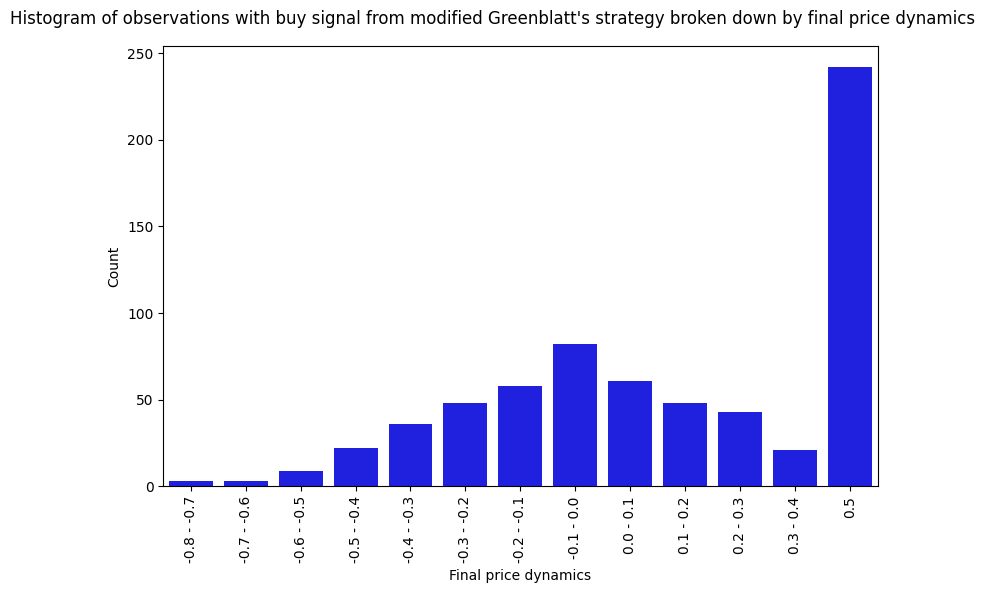

In [262]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        greenblatt_df[greenblatt_df.mod_buy == 'Yes'].final_price_dynamics,
        bins=list(np.linspace(-.8, .5, 14)),
        labels=[f'{round(i, 1)} - {round(i + .1, 1)}' for i in np.linspace(-.8, .3, 12)] + ['0.5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of observations with buy signal from modified Greenblatt\'s strategy broken down by final price dynamics')

plt.tight_layout();

The modified Greenblatt's strategy was profitable in 40 of analyzed quarters and outperformed zero effort strategy (i.e. investing in WIG) in 39 of analyzed periods. Moreover, the modified strategy brought the total profit of 9260%, while the original strategy brought the total loss of almost -866%. The average return on the modified strategy was 147%.



In [263]:
greenblatt_return_df['Modified Greenblatt\'s strategy'] = greenblatt_df[
        greenblatt_df.mod_buy == 'Yes'
    ].groupby('quarter').final_price_dynamics.sum()

greenblatt_portfolio_df['buy_in_q'] = pd.Series(
    greenblatt_df[
        greenblatt_df.mod_buy == 'Yes'
    ].groupby('quarter').quarter.count().reindex(sorted(dataset.quarter.unique())).fillna(0)
)
greenblatt_portfolio_df['sell_in_q'] = pd.Series(
    greenblatt_df[
        greenblatt_df.mod_buy == 'Yes'
    ].groupby('sell_in_q').sell_in_q.count().reindex(sorted(dataset.quarter.unique())).fillna(0)
)
greenblatt_portfolio_df['Modified Greenblatt\'s strategy'] = (
    greenblatt_portfolio_df.buy_in_q - greenblatt_portfolio_df.sell_in_q
).cumsum()
greenblatt_portfolio_df.drop(['buy_in_q', 'sell_in_q'], axis=1, inplace=True)

strategy_stat(dataset, greenblatt_return_df, greenblatt_portfolio_df, 'Modified Greenblatt\'s strategy')

Number of quarters with buy signal from Modified Greenblatt's strategy: 63
Number of quarters with sufficient portfolio size: 59
Number of profitable quarters using Modified Greenblatt's strategy: 40
Number of profitable quarters using zero effort strategy: 43
Number of quarters in which Modified Greenblatt's strategy outperformed zero effort strategy: 39
Total return on Modified Greenblatt's strategy: 9260.21%
Total return on zero effort strategy: 386.32%
Average return on Modified Greenblatt's strategy: 146.99%
Average return on zero effort strategy: 5.6%


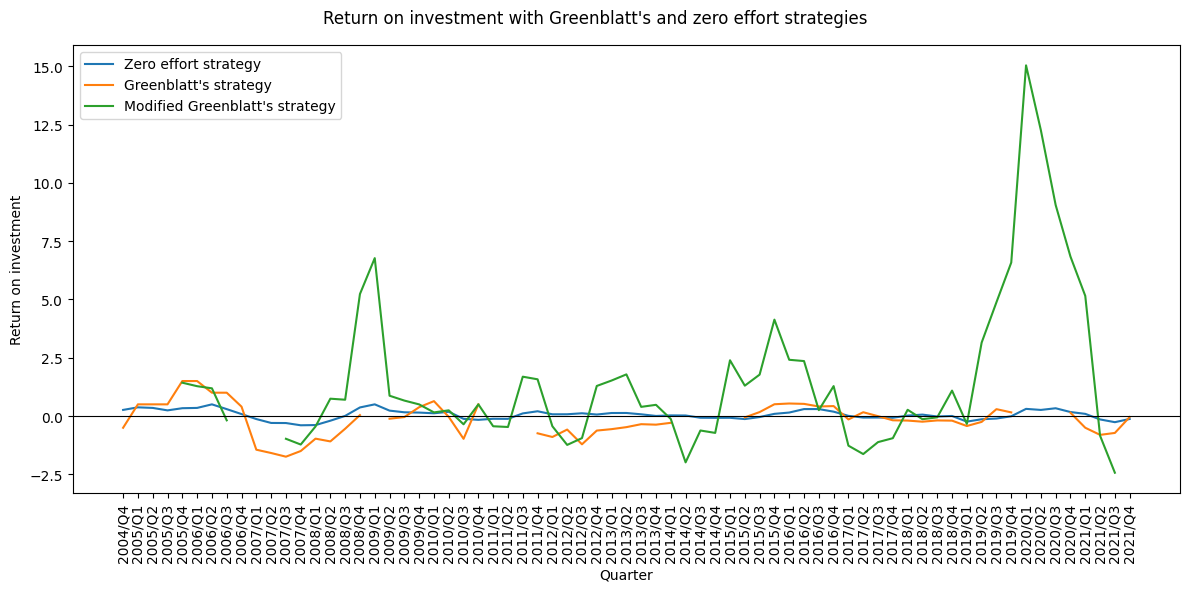

In [173]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(
    greenblatt_return_df.index,
    greenblatt_return_df
)

ax.axhline(0, color='black', linewidth=.8)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

ax.legend(labels=['Zero effort strategy', 'Greenblatt\'s strategy', 'Modified Greenblatt\'s strategy'])

plt.suptitle('Return on investment with Greenblatt\'s and zero effort strategies')

plt.tight_layout();

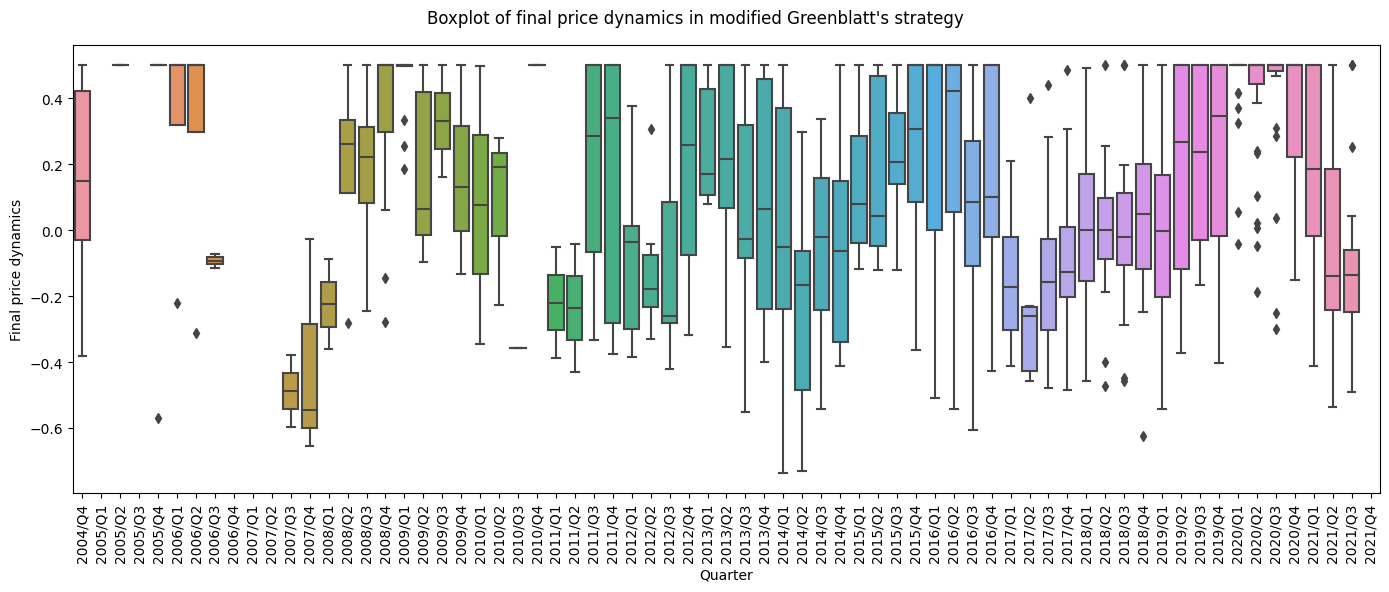

In [258]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    data=greenblatt_df[greenblatt_df.mod_buy == 'Yes'],
    x='quarter',
    y='final_price_dynamics',
    order=quarters,
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Quarter')
ax.set_ylabel('Final price dynamics')

plt.suptitle('Boxplot of final price dynamics in modified Greenblatt\'s strategy')

plt.tight_layout();

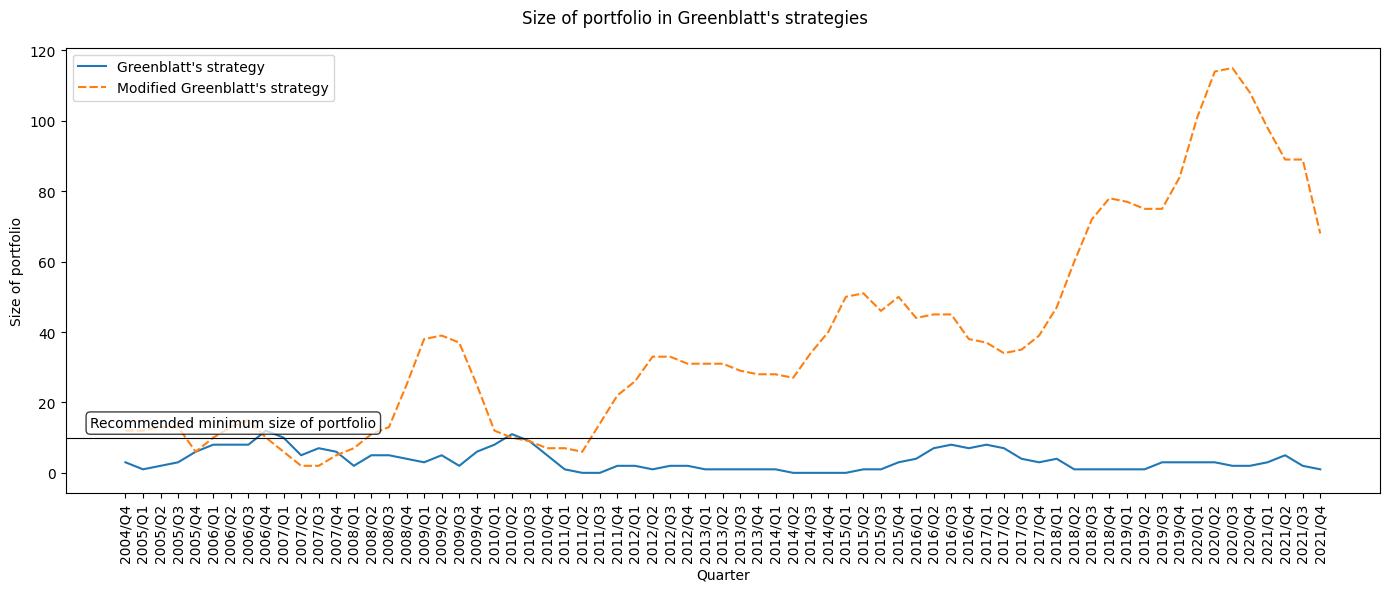

In [236]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=greenblatt_portfolio_df,
    ax=ax
)

ax.axhline(10, color='black', linewidth=.8)
ax.text(
    -2, 13,
    'Recommended minimum size of portfolio',
    color='black',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.75)
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Quarter')
ax.set_ylabel('Size of portfolio')

plt.suptitle('Size of portfolio in Greenblatt\'s strategies')

plt.tight_layout();

# Martin Zweig's strategy

This strategy assumes, that we invest only in companies which:
- have net earnings y/y greater than 115% (net earnings = sales revenues - cost of revenue - tax)
- have sales revenues y/y greater than 115%
- have net earnings in the last quarter greater than net earnings in the corresponding quarter of the previous year (e.g. for observation in Q3 2020 the net earnings in Q2 2020 have to be greater than net earnings in Q2 2019)
- have net earnings in two quarters ago greater than net earnings in the corresponding quarter of the previous year (e.g. for observation in Q3 2020 the net earnings in Q1 2020 have to be greater than net earnings in Q1 2019)
- have sales revenues in the last quarter greater than sales revenues in the corresponding quarter of the previous year
- have sales revenues in two quarters ago greater than sales revenues in the corresponding quarter of the previous year
- have relative strength from the last 6 months greater than 0 (relative strength = price dynamics / WIG dynamics)
- have price/earnings (P/E) ratio lower than doubled average price/earnings ratio for whole market in given quarter

For this strategy the following variables would be used:
- **final_price_dynamics** and **interesting_investment**: target variable described above;
- **final_wig_dynamics**: benchmark feature;
- **net_earnings**: various variables with net earnings values in different quarters;
- **sales_revenues**: various variables with sales revenues values in different quarters;
- **relative_strength_6m**: change of company's price in the last 6 months divided by change of Warsaw Stock Exchange Index value in the last 6 months;
- **price_earnings**: company's price divided by net earnings divided by number of shares;
- **avg_price_earnings**: average price/earnings ratio for whole market in given quarter;
- **buy**: signal from Zweig's strategy, *Yes* if company should be bought, *No* otherwise.

In [127]:
# Filter data
zweig_df = dataset.filter([
    'quarter', 'company_code', 'interesting_investment',
    'final_price_dynamics', 'adj_best_price_dynamics_y', 'adj_price_dynamics_y',
    'final_wig_dynamics', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
    'net_earnings_yy', 'net_earnings_1Q', 'net_earnings_2Q', 'net_earnings_5Q', 'net_earnings_6Q',
    'sales_revenues_yy', 'sales_revenues_1Q', 'sales_revenues_2Q', 'sales_revenues_5Q', 'sales_revenues_6Q',
    'relative_strength_6m', 'price_earnings', 'avg_price_earnings'
])

# Add column 'buy' for observations, which meet strategy conditions
zweig_df['buy'] = np.where(
    (zweig_df.net_earnings_yy > 1.15) &
    (zweig_df.sales_revenues_yy > 1.15) &
    (zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q) &
    (zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q) &
    (zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q) &
    (zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q) &
    (zweig_df.relative_strength_6m > 0) &
    (zweig_df.price_earnings < 2 * zweig_df.avg_price_earnings),
    'Yes', 'No'
)
zweig_df = zweig_df.dropna()


The analyzed subset contains 12189 observations (64% of original dataset). The distribution of **final_price_dynamics** is close to original set. The subset omitted 1279 **interesting_investment** observations (2998 in original set vs 1719 in subset). However, the Zweig's strategy classified 115 observations as worth buying. What is worse, 72 of them made a loss, and another 29 made a profit below 50%.

In [128]:
print('The basic statistics of final price dynamics in Zweig\'s strategy:')
print(zweig_df.final_price_dynamics.describe())
print('\nInteresting companies in Zweig\'s strategy:')
print(zweig_df.interesting_investment.value_counts())
print(f'\nNumber of buy signals from Zweig\'s strategy: {zweig_df.buy.value_counts()[1]}')

The basic statistics of final price dynamics in Zweig's strategy:
count   12189.00
mean        0.01
std         0.30
min        -0.79
25%        -0.20
50%        -0.01
75%         0.23
max         0.50
Name: final_price_dynamics, dtype: float64

Interesting companies in Zweig's strategy:
No       6318
Maybe    4152
Yes      1719
Name: interesting_investment, dtype: int64

Number of buy signals from Zweig's strategy: 115


In [129]:
pd.crosstab(
    zweig_df.interesting_investment,
    zweig_df.buy, 
    rownames=['Interesting investment:'],
    colnames=['Buy signal from Zweig\'s strategy:']
).reindex(['No', 'Maybe', 'Yes'], axis=0)

Buy signal from Zweig's strategy:    No  Yes
Interesting investment:                     
No                                 6246   72
Maybe                              4123   29
Yes                                1705   14

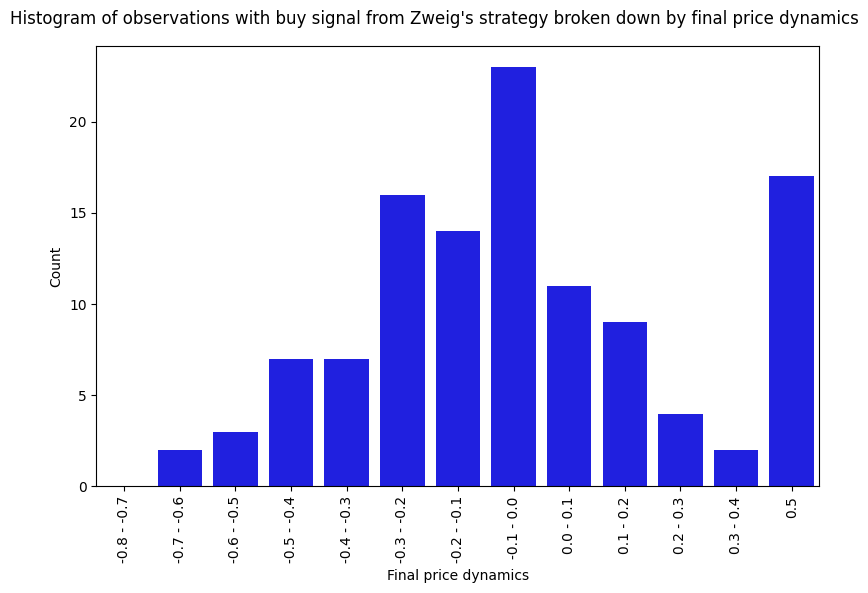

In [130]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        zweig_df[zweig_df.buy == 'Yes'].final_price_dynamics,
        bins=list(np.linspace(-.8, .5, 14)),
        labels=[f'{round(i, 1)} - {round(i + .1, 1)}' for i in np.linspace(-.8, .3, 12)] + ['0.5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle('Histogram of observations with buy signal from Zweig\'s strategy broken down by final price dynamics')

plt.tight_layout();

The Zweig's strategy was profitable in 26% of quarters and outperformed zero effort strategy (i.e. investing in WIG) in 29% of periods. The Zweig's stategy brought the total loss of -413% with negative average return (-8%). Moreover, there were 19 quarters, when there were no companies classified as worth buying.

In [57]:
zweig_return_df = pd.DataFrame({
    'Zero effort strategy':dataset.groupby('quarter').final_wig_dynamics.mean(),
    'Zweig\'s strategy':zweig_df[
        zweig_df.buy == 'Yes'
    ].groupby('quarter').final_price_dynamics.sum()
})

z_quarters_strat = zweig_return_df['Zweig\'s strategy'].count()

z_quarters_profit_strat = zweig_return_df[
    zweig_return_df['Zweig\'s strategy'] > 0
]['Zweig\'s strategy'].count()

z_quarters_profit_wig = zweig_return_df[
    zweig_return_df['Zero effort strategy'] > 0
]['Zero effort strategy'].count()

z_quarters_perform_strat = zweig_return_df[
    zweig_return_df['Zweig\'s strategy'] > zweig_return_df['Zero effort strategy']
]['Zweig\'s strategy'].count()

z_strategy_return = (100 * zweig_return_df['Zweig\'s strategy'].sum()).round(2)
z_avg_strategy_return = (100 * zweig_return_df['Zweig\'s strategy'].mean()).round(2)

z_wig_return = (100 * zweig_return_df['Zero effort strategy'].sum()).round(2)
z_avg_wig_return =(100 * zweig_return_df['Zero effort strategy'].mean()).round(2)

print(f'Number of quarters with buy signal from Zweig\'s strategy: {z_quarters_strat}')
print(f'Number of profitable quarters using Zweig\'s strategy: {z_quarters_profit_strat}')
print(f'Number of profitable quarters using zero effort strategy: {z_quarters_profit_wig}')
print(f'Number of quarters in which Zweig\'s strategy outperformed zero effort strategy: {z_quarters_perform_strat}')
print(f'Total return on Zweig\'s strategy: {z_strategy_return}%')
print(f'Total return on zero effort strategy: {z_wig_return}%')
print(f'Average return on Zweig\'s strategy: {z_avg_strategy_return}%')
print(f'Average return on zero effort strategy: {z_avg_wig_return}%')

Number of quarters with buy signal from Zweig's strategy: 57
Number of profitable quarters using Zweig's strategy: 22
Number of profitable quarters using zero effort strategy: 43
Number of quarters in which Zweig's strategy outperformed zero effort strategy: 22
Total return on Zweig's strategy: -948.67%
Total return on zero effort strategy: 386.32%
Average return on Zweig's strategy: -16.64%
Average return on zero effort strategy: 5.6%


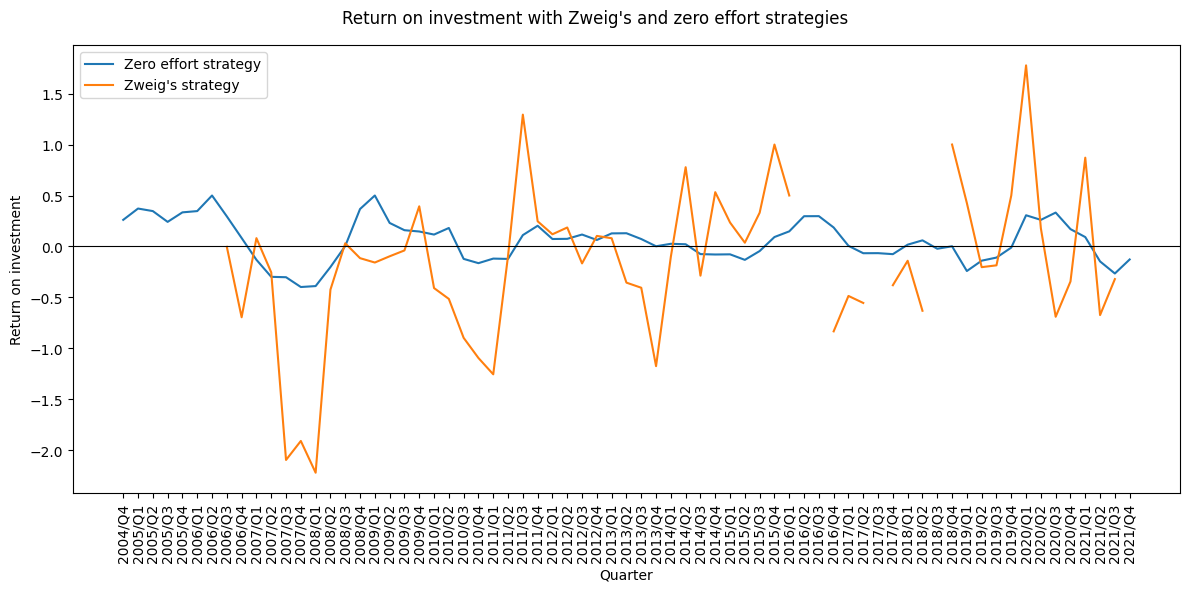

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(
    zweig_return_df.index,
    zweig_return_df
)

ax.axhline(0, color='black', linewidth=.8)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

ax.legend(labels=['Zero effort strategy', 'Zweig\'s strategy'])

plt.suptitle('Return on investment with Zweig\'s and zero effort strategies')

plt.tight_layout();

The range of net earnings y/y feature is from -16083 to 3264 with mean value of 2.3, though the median is 0.15. Almost 25% of observations met the criterion for this variable. However, more than 40% of observations had negative dynamics of net earnings.

The boxplots below indicate, that Zweig's treshold for net earnings y/y generally seems reasonable. Observations with values over 1.15 perform significantly better than those below this treshold. Moreover, they give greater chance of return of investment of at least 50% and the lowest risk of loss. We may possibly narrow the range of values to 1.15 - 7 to lower the risk of a bad investment.

In [59]:
print('The basic statistics of net earnings y/y in Zweig\'s strategy:')
print(zweig_df.net_earnings_yy.describe())
print('\nNet earnings y/y in Zweig\'s strategy:')
print(pd.Series(np.where(
    zweig_df.net_earnings_yy > 1.15,
    'Over 115%', 'Below 115%'
)).value_counts())

The basic statistics of net earnings y/y in Zweig's strategy:
count    12189.00
mean         2.28
std        157.49
min     -16083.00
25%         -0.40
50%          0.15
75%          1.12
max       3234.00
Name: net_earnings_yy, dtype: float64

Net earnings y/y in Zweig's strategy:
Below 115%    9186
Over 115%     3003
dtype: int64


In [60]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.countplot(
    x=pd.cut(
        zweig_df.net_earnings_yy,
        bins=[-2e4, 0, 1.15] + list(np.arange(2, 11)) + [4e3],
        labels=['Below 0', '0 - 1.15', '1.15 - 2'] + [f'{i} - {i+1}' for i in range(2, 10)] + ['Over 10']
    ),
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.cut(
        zweig_df[zweig_df.net_earnings_yy < 1.15].net_earnings_yy,
        bins=[-2e4] + list(np.linspace(-2, 1, 16)) + [1.15],
        labels=['Below -2'] + [f'{round(i, 1)} - {round(i+.2, 1)}' for i in np.linspace(-2, .8, 15)] + ['Over 1']
    ),
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.cut(
        zweig_df.net_earnings_yy,
        bins=[-2e4, 0, 1.15, 4e3],
        labels=['Below 0', '0 - 1.15', 'Over 1.15']
    ),
    color='blue',
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Net earnings y/y')
    axs[i].set_ylabel('Count')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Histograms of net earnings y/y in Zweig\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Net earnings y/y below 1.15')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

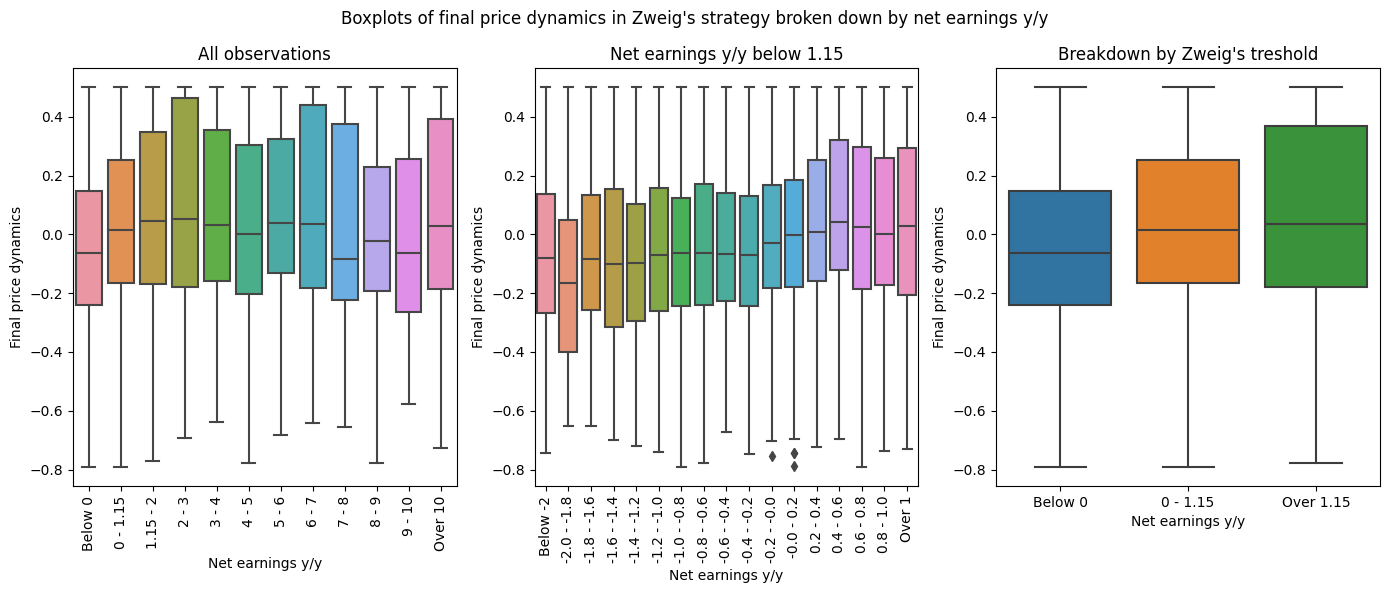

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        zweig_df.net_earnings_yy,
        bins=[-2e4, 0, 1.15] + list(np.arange(2, 11)) + [4e3],
        labels=['Below 0', '0 - 1.15', '1.15 - 2'] + [f'{i} - {i+1}' for i in range(2, 10)] + ['Over 10']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        zweig_df[zweig_df.net_earnings_yy < 1.15].net_earnings_yy,
        bins=[-2e4] + list(np.linspace(-2, 1, 16)) + [1.15],
        labels=['Below -2'] + [f'{round(i, 1)} - {round(i+.2, 1)}' for i in np.linspace(-2, .8, 15)] + ['Over 1']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[1]
)

sns.boxplot(
    x=pd.cut(
        zweig_df.net_earnings_yy,
        bins=[-2e4, 0, 1.15, 4e3],
        labels=['Below 0', '0 - 1.15', 'Over 1.15']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Net earnings y/y')
    axs[i].set_ylabel('Final price dynamics')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Boxplots of final price dynamics in Zweig\'s strategy broken down by net earnings y/y')
axs[0].set_title('All observations')
axs[1].set_title('Net earnings y/y below 1.15')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

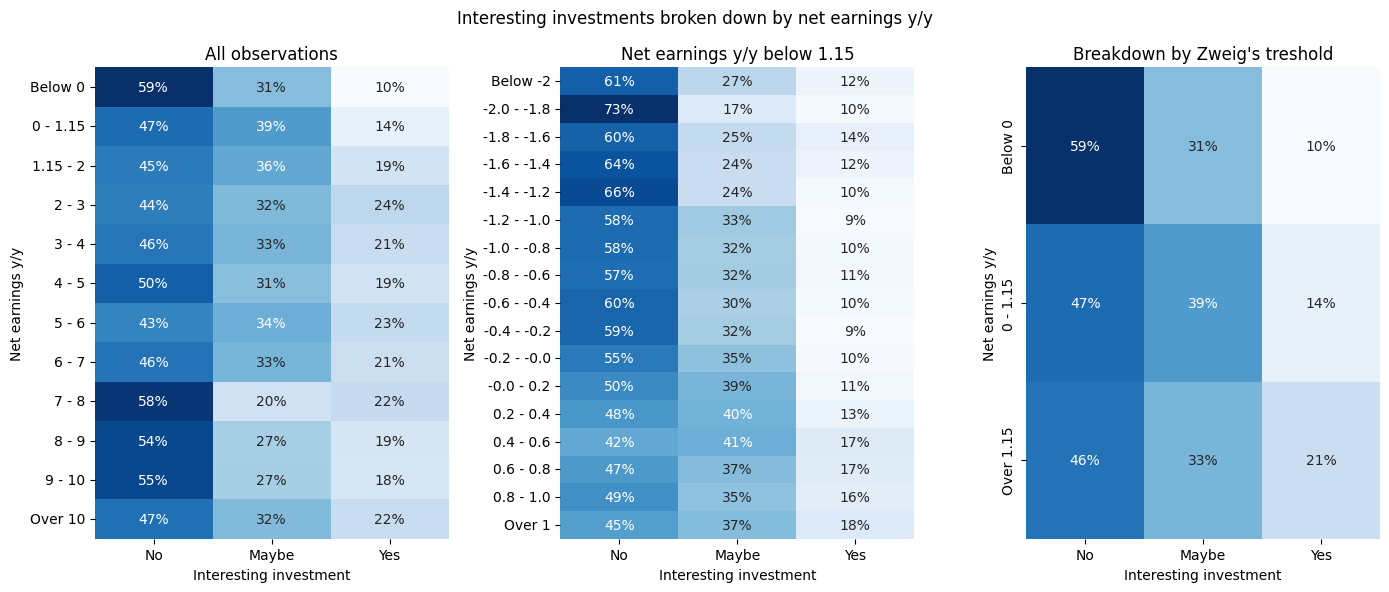

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df.net_earnings_yy,
            bins=[-2e4, 0, 1.15] + list(np.arange(2, 11)) + [4e3],
            labels=['Below 0', '0 - 1.15', '1.15 - 2'] + [f'{i} - {i+1}' for i in range(2, 10)] + ['Over 10']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df[zweig_df.net_earnings_yy < 1.15].net_earnings_yy,
            bins=[-2e4] + list(np.linspace(-2, 1, 16)) + [1.15],
            labels=['Below -2'] + [f'{round(i, 1)} - {round(i+.2, 1)}' for i in np.linspace(-2, .8, 15)] + ['Over 1']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df.net_earnings_yy,
            bins=[-2e4, 0, 1.15, 4e3],
        labels=['Below 0', '0 - 1.15', 'Over 1.15']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='y', labelrotation=0)
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Net earnings y/y')
axs[i].tick_params(axis='y', labelrotation=90)

plt.suptitle('Interesting investments broken down by net earnings y/y')
axs[0].set_title('All observations')
axs[1].set_title('Net earnings y/y below 1.15')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

The range of sales revenues y/y feature is from -229 to 7744 with mean value of 1.95, though the median is 0.09. Only about 5% of observations meet the criteria for this variable. Moreover, 1/3 of observations had negative dynamics of sales revenues.

The charts below indicate, that companies with sales revenues y/y between 0 and 1.15 actually performs better than those over 1.15. While there is a slightly lower percentage of investments making profit over 50% in this range, there is also a significantly lower percentage of loss-making observations. This range can be narrowed down even further - to 0.2 - 1.4.

In [63]:
print('The basic statistics of sales revenues y/y in Zweig\'s strategy:')
print(zweig_df.sales_revenues_yy.describe())
print('\nSales revenues y/y in Zweig\'s strategy:')
print(pd.Series(np.where(
    zweig_df.sales_revenues_yy > 1.15,
    'Over 115%', 'Below 115%'
)).value_counts())

The basic statistics of sales revenues y/y in Zweig's strategy:
count   12189.00
mean        1.95
std        74.34
min      -229.28
25%        -0.05
50%         0.09
75%         0.28
max      7744.29
Name: sales_revenues_yy, dtype: float64

Sales revenues y/y in Zweig's strategy:
Below 115%    11511
Over 115%       678
dtype: int64


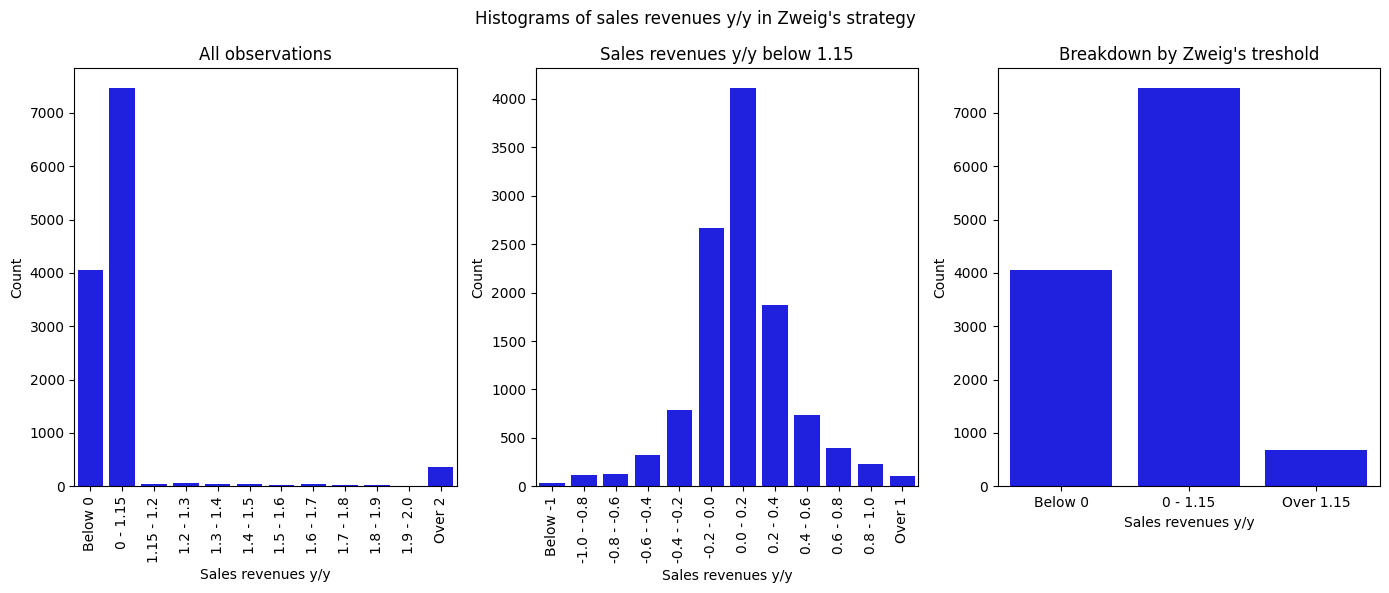

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.countplot(
    x=pd.cut(
        zweig_df.sales_revenues_yy,
        bins=[-3e2, 0, 1.15] + list(np.arange(1.2, 2.1, .1)) + [8e3],
        labels=['Below 0', '0 - 1.15', '1.15 - 1.2'] + [f'{round(i, 1)} - {round(i+.1, 1)}' for i in np.arange(1.2, 2, .1)] + ['Over 2']
    ),
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.cut(
        zweig_df[zweig_df.sales_revenues_yy < 1.15].sales_revenues_yy,
        bins=[-3e2] + list(np.linspace(-1, 1, 11)) + [1.15],
        labels=['Below -1'] + [f'{round(i, 1)} - {round(i+.2, 1)}' for i in np.linspace(-1, .8, 10)] + ['Over 1']
    ),
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.cut(
        zweig_df.sales_revenues_yy,
        bins=[-3e2, 0, 1.15, 8e3],
        labels=['Below 0', '0 - 1.15', 'Over 1.15']
    ),
    color='blue',
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Sales revenues y/y')
    axs[i].set_ylabel('Count')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Histograms of sales revenues y/y in Zweig\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Sales revenues y/y below 1.15')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        zweig_df.sales_revenues_yy,
        bins=[-3e2, 0, 1.15] + list(np.arange(1.2, 2.1, .1)) + [8e3],
        labels=['Below 0', '0 - 1.15', '1.15 - 1.2'] + [f'{round(i, 1)} - {round(i+.1, 1)}' for i in np.arange(1.2, 2, .1)] + ['Over 2']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        zweig_df[zweig_df.sales_revenues_yy < 1.15].sales_revenues_yy,
        bins=[-3e2] + list(np.linspace(-1, 1, 11)) + [1.15],
        labels=['Below -1'] + [f'{round(i, 1)} - {round(i+.2, 1)}' for i in np.linspace(-1, .8, 10)] + ['Over 1']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[1]
)

sns.boxplot(
    x=pd.cut(
        zweig_df.sales_revenues_yy,
        bins=[-3e2, 0, 1.15, 8e3],
        labels=['Below 0', '0 - 1.15', 'Over 1.15']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Sales revenues y/y')
    axs[i].set_ylabel('Final price dynamics')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Boxplots of final price dynamics in Zweig\'s strategy broken down by sales revenues y/y')
axs[0].set_title('All observations')
axs[1].set_title('Sales revenues y/y below 1.15')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

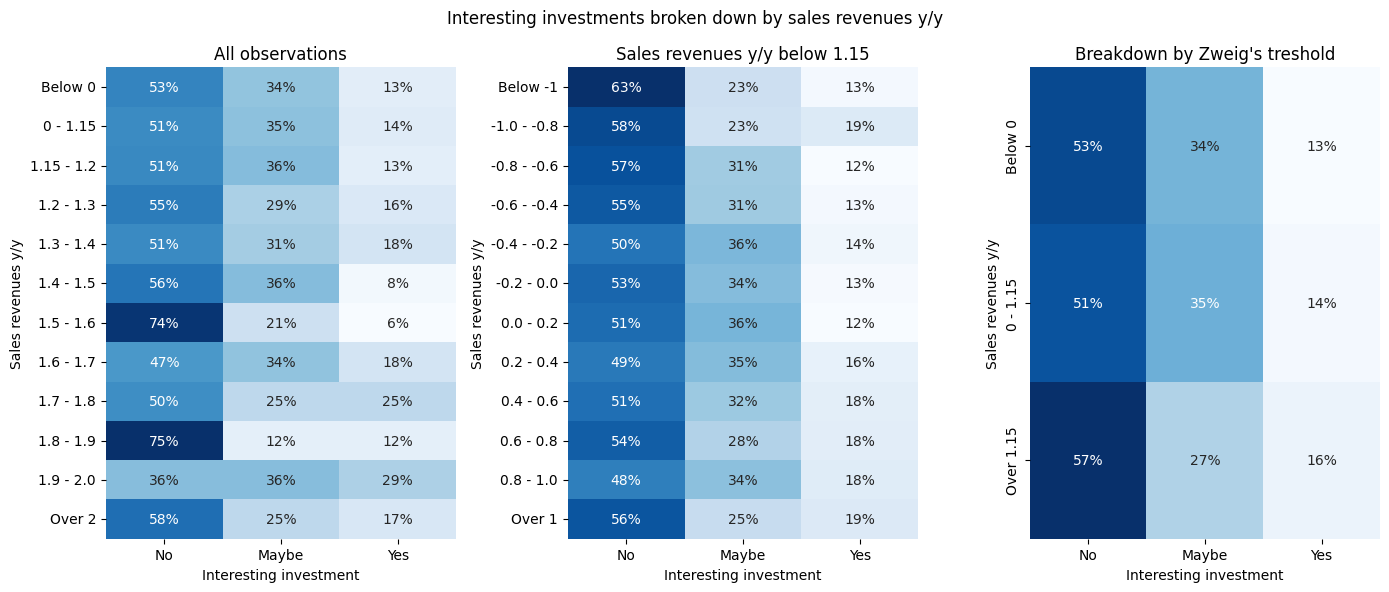

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df.sales_revenues_yy,
            bins=[-3e2, 0, 1.15] + list(np.arange(1.2, 2.1, .1)) + [8e3],
            labels=['Below 0', '0 - 1.15', '1.15 - 1.2'] + [f'{round(i, 1)} - {round(i+.1, 1)}' for i in np.arange(1.2, 2, .1)] + ['Over 2']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df[zweig_df.sales_revenues_yy < 1.15].sales_revenues_yy,
            bins=[-3e2] + list(np.linspace(-1, 1, 11)) + [1.15],
            labels=['Below -1'] + [f'{round(i, 1)} - {round(i+.2, 1)}' for i in np.linspace(-1, .8, 10)] + ['Over 1']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df.sales_revenues_yy,
            bins=[-3e2, 0, 1.15, 8e3],
            labels=['Below 0', '0 - 1.15', 'Over 1.15']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='y', labelrotation=0)
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Sales revenues y/y')
axs[i].tick_params(axis='y', labelrotation=90)

plt.suptitle('Interesting investments broken down by sales revenues y/y')
axs[0].set_title('All observations')
axs[1].set_title('Sales revenues y/y below 1.15')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

The next two criteria filter companies, which in last two quarters had higher net earnings than in the corresponding quarters the year before. There are 4787 observations which meet both criteria. Such companies performed only slightly better than those, which were not able to fullfill these criteria.

In [67]:
print('Observations with net earnings in previous quarter higher than net earnings 5 quarters ago:')
print(pd.Series(np.where(
    zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q,
    'Yes', 'No'
)).value_counts())

print('\nObservations with net earnings 2 quarters ago higher than net earnings 6 quarters ago:')
print(pd.Series(np.where(
    zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q,
    'Yes', 'No'
)).value_counts())

print('\nObservations which meet both criteria:')
print(pd.Series(np.where(
    (zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q)
    & (zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q),
    'Yes', 'No'
)).value_counts())

Observations with net earnings in previous quarter higher than net earnings 5 quarters ago:
Yes    7226
No     4963
dtype: int64

Observations with net earnings 2 quarters ago higher than net earnings 6 quarters ago:
Yes    7300
No     4889
dtype: int64

Observations which meet both criteria:
No     7402
Yes    4787
dtype: int64


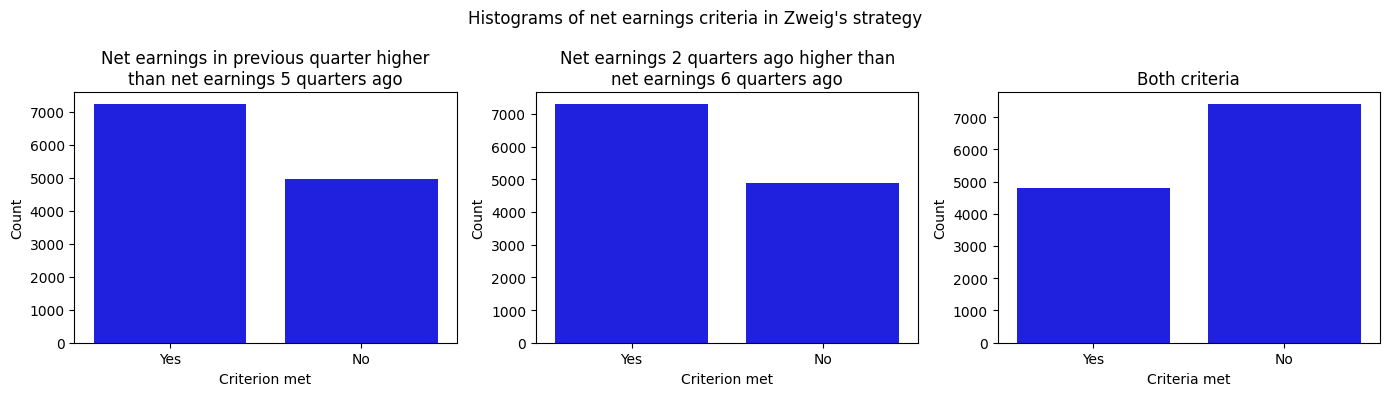

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(
    x=pd.Series(np.where(
        zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q,
        'Yes', 'No'
    )),
    color='blue',
    order=['Yes', 'No'],
    ax=axs[0]
)

sns.countplot(
    x=pd.Series(np.where(
        zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q,
        'Yes', 'No'
    )),
    order=['Yes', 'No'],
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.Series(np.where(
        (zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q)
        & (zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q),
        'Yes', 'No'
    )),
    order=['Yes', 'No'],
    color='blue',
    ax=axs[2]
)

for i in range(3):
    axs[i].set_xlabel('Criterion met')
    axs[i].set_ylabel('Count')
axs[2].set_xlabel('Criteria met')

plt.suptitle('Histograms of net earnings criteria in Zweig\'s strategy')
axs[0].set_title('\n'.join(wrap('Net earnings in previous quarter higher than net earnings 5 quarters ago', 40)))
axs[1].set_title('\n'.join(wrap('Net earnings 2 quarters ago higher than net earnings 6 quarters ago', 40)))
axs[2].set_title('Both criteria')

plt.tight_layout();

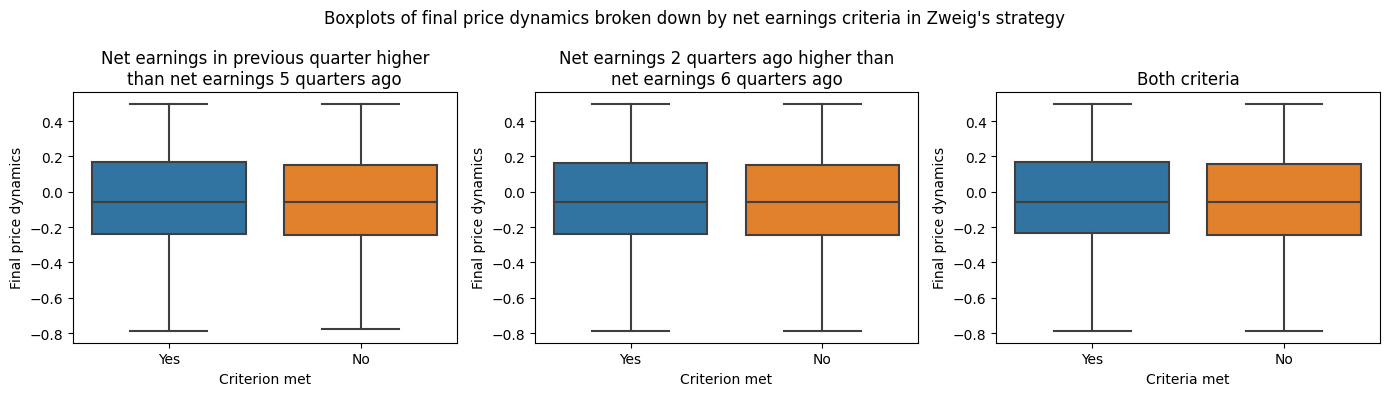

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.boxplot(
    x=pd.Series(np.where(
        zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q,
        'Yes', 'No'
    )),
    y=zweig_df.final_price_dynamics,
    order=['Yes', 'No'],
    ax=axs[0]
)

sns.boxplot(
    x=pd.Series(np.where(
        zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q,
        'Yes', 'No'
    )),
    y=zweig_df.final_price_dynamics,
    order=['Yes', 'No'],
    ax=axs[1]
)

sns.boxplot(
    x=pd.Series(np.where(
        (zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q)
        & (zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q),
        'Yes', 'No'
    )),
    y=zweig_df.final_price_dynamics,
    order=['Yes', 'No'],
    ax=axs[2]
)

for i in range(3):
    axs[i].set_xlabel('Criterion met')
    axs[i].set_ylabel('Final price dynamics')
axs[2].set_xlabel('Criteria met')

plt.suptitle('Boxplots of final price dynamics broken down by net earnings criteria in Zweig\'s strategy')
axs[0].set_title('\n'.join(wrap('Net earnings in previous quarter higher than net earnings 5 quarters ago', 40)))
axs[1].set_title('\n'.join(wrap('Net earnings 2 quarters ago higher than net earnings 6 quarters ago', 40)))
axs[2].set_title('Both criteria')

plt.tight_layout();

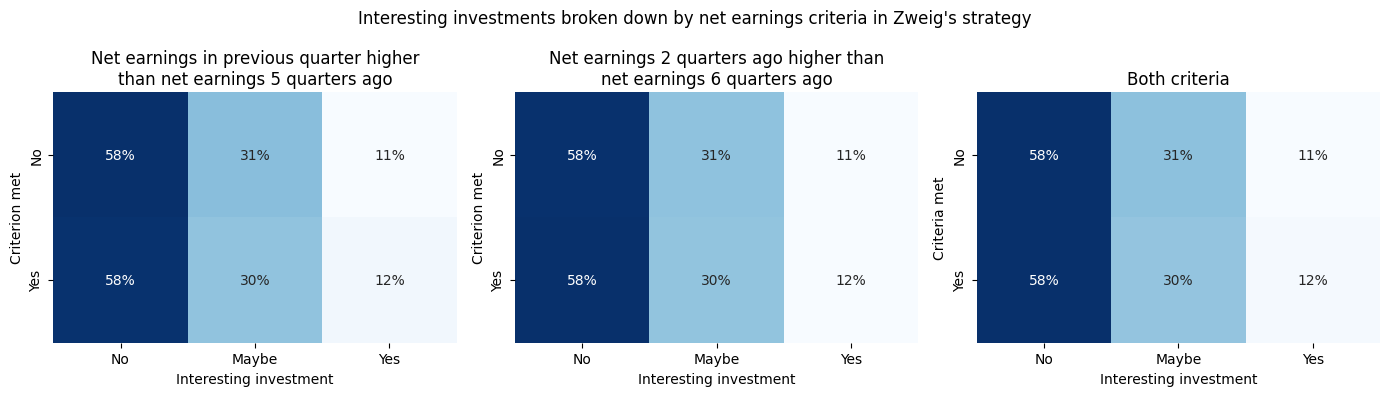

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q,
            'Yes', 'No'
        )),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q,
            'Yes', 'No'
        )),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            (zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q)
            & (zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q),
            'Yes', 'No'
        )),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[2]
)

for i in range(3):
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Criterion met')
axs[2].set_ylabel('Criteria met')

plt.suptitle('Interesting investments broken down by net earnings criteria in Zweig\'s strategy')
axs[0].set_title('\n'.join(wrap('Net earnings in previous quarter higher than net earnings 5 quarters ago', 40)))
axs[1].set_title('\n'.join(wrap('Net earnings 2 quarters ago higher than net earnings 6 quarters ago', 40)))
axs[2].set_title('Both criteria')

plt.tight_layout();

The next pair of criteria is similar to the previous - with the difference that it relates to sales revenue. There are 6549 observations which meet both criteria. Such companies performed better than those, which were not able to fullfill these criteria - with proportion of interesting investments higher by 3 percentage points and risk of bad investment lower by 4 percentage points.

In [71]:
print('Observations with sales revenues in previous quarter higher than sales revenues 5 quarters ago:')
print(pd.Series(np.where(
    zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q,
    'Yes', 'No'
)).value_counts())

print('\nObservations with sales revenues 2 quarters ago higher than sales revenues 6 quarters ago:')
print(pd.Series(np.where(
    zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q,
    'Yes', 'No'
)).value_counts())

print('\nObservations which meet both criteria:')
print(pd.Series(np.where(
    (zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q)
    & (zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q),
    'Yes', 'No'
)).value_counts())

Observations with sales revenues in previous quarter higher than sales revenues 5 quarters ago:
Yes    8187
No     4002
dtype: int64

Observations with sales revenues 2 quarters ago higher than sales revenues 6 quarters ago:
Yes    8188
No     4001
dtype: int64

Observations which meet both criteria:
Yes    6549
No     5640
dtype: int64


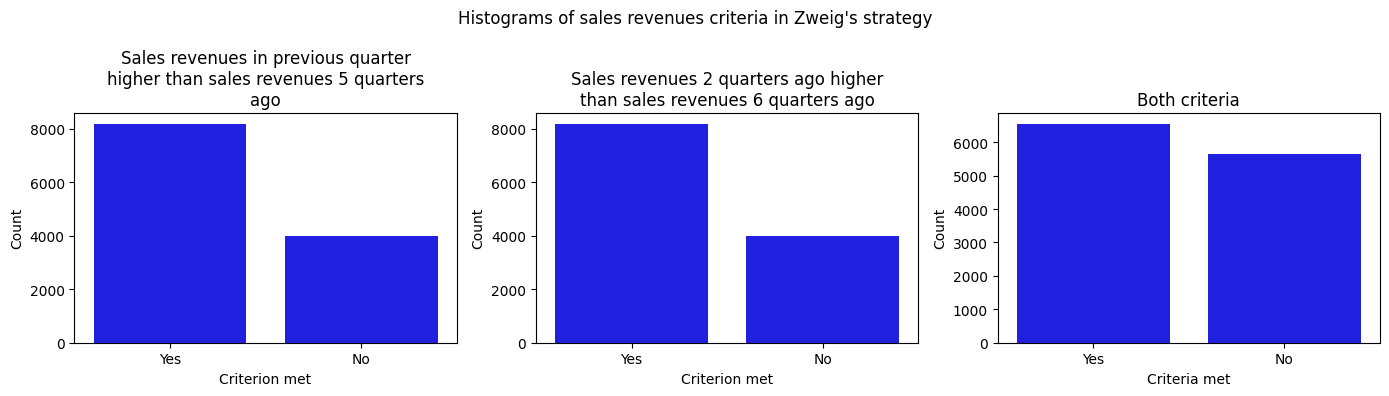

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(
    x=pd.Series(np.where(
        zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q,
        'Yes', 'No'
    )),
    order=['Yes', 'No'],
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.Series(np.where(
        zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q,
        'Yes', 'No'
    )),
    order=['Yes', 'No'],
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.Series(np.where(
        (zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q)
        & (zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q),
        'Yes', 'No'
    )),
    order=['Yes', 'No'],
    color='blue',
    ax=axs[2]
)

for i in range(3):
    axs[i].set_xlabel('Criterion met')
    axs[i].set_ylabel('Count')
axs[2].set_xlabel('Criteria met')

plt.suptitle('Histograms of sales revenues criteria in Zweig\'s strategy')
axs[0].set_title('\n'.join(wrap('Sales revenues in previous quarter higher than sales revenues 5 quarters ago', 40)))
axs[1].set_title('\n'.join(wrap('Sales revenues 2 quarters ago higher than sales revenues 6 quarters ago', 40)))
axs[2].set_title('Both criteria')

plt.tight_layout();

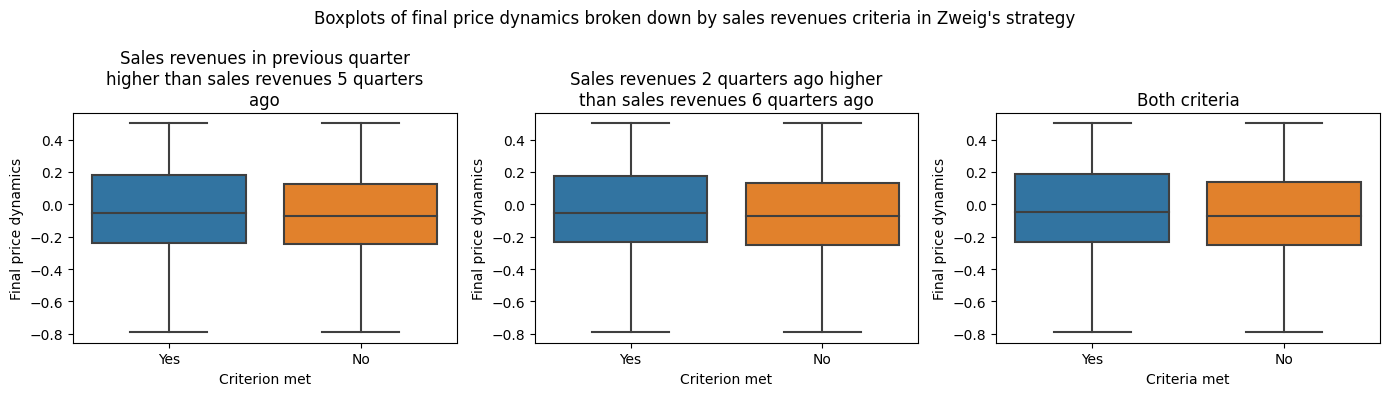

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.boxplot(
    x=pd.Series(np.where(
        zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q,
        'Yes', 'No'
    )),
    y=zweig_df.final_price_dynamics,
    order=['Yes', 'No'],
    ax=axs[0]
)

sns.boxplot(
    x=pd.Series(np.where(
        zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q,
        'Yes', 'No'
    )),
    y=zweig_df.final_price_dynamics,
    order=['Yes', 'No'],
    ax=axs[1]
)

sns.boxplot(
    x=pd.Series(np.where(
        (zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q)
        & (zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q),
        'Yes', 'No'
    )),
    y=zweig_df.final_price_dynamics,
    order=['Yes', 'No'],
    ax=axs[2]
)

for i in range(3):
    axs[i].set_xlabel('Criterion met')
    axs[i].set_ylabel('Final price dynamics')
axs[2].set_xlabel('Criteria met')

plt.suptitle('Boxplots of final price dynamics broken down by sales revenues criteria in Zweig\'s strategy')
axs[0].set_title('\n'.join(wrap('Sales revenues in previous quarter higher than sales revenues 5 quarters ago', 40)))
axs[1].set_title('\n'.join(wrap('Sales revenues 2 quarters ago higher than sales revenues 6 quarters ago', 40)))
axs[2].set_title('Both criteria')

plt.tight_layout();

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q,
            'Yes', 'No'
        )),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q,
            'Yes', 'No'
        )),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            (zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q)
            & (zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q),
            'Yes', 'No'
        )),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[2]
)

for i in range(3):
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Criterion met')
axs[2].set_ylabel('Criteria met')

plt.suptitle('Interesting investments broken down by sales revenues criteria in Zweig\'s strategy')
axs[0].set_title('\n'.join(wrap('Sales revenues in previous quarter higher than sales revenues 5 quarters ago', 40)))
axs[1].set_title('\n'.join(wrap('Sales revenues 2 quarters ago higher than sales revenues 6 quarters ago', 40)))
axs[2].set_title('Both criteria')

plt.tight_layout();

The range of relative strength 6M feature is from -870 to 246 with mean value of 0.11 and median 0.57. Almost 60% of observations met the criterion for this variable. Such companies performed only slightly better than those, which were not able to fullfill these criteria. Changing the threshold for this variable will not improve significantly its performance.

In [75]:
print('The basic statistics of relative strength 6M in Zweig\'s strategy:')
print(zweig_df.relative_strength_6m.describe())
print('\nRelative strength 6M in Zweig\'s strategy:')
print(pd.Series(np.where(
    zweig_df.relative_strength_6m > 0,
    'Over 0', 'Below 0'
)).value_counts())

The basic statistics of relative strength 6M in Zweig's strategy:
count   12189.00
mean        0.11
std        14.52
min      -869.57
25%        -1.27
50%         0.57
75%         2.34
max       245.69
Name: relative_strength_6m, dtype: float64

Relative strength 6M in Zweig's strategy:
Over 0     7287
Below 0    4902
dtype: int64


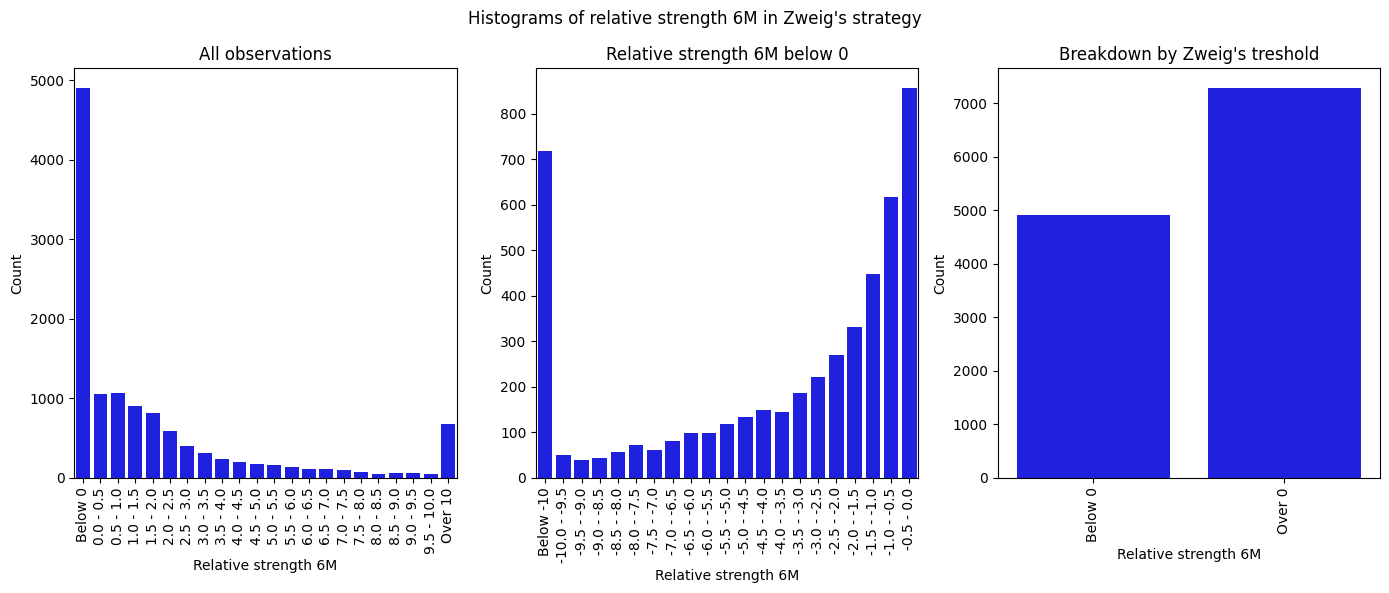

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.countplot(
    x=pd.cut(
        zweig_df.relative_strength_6m,
        bins=[-900] + list(np.arange(0, 10.5, .5)) + [250],
        labels=['Below 0'] + [f'{i} - {i+.5}' for i in np.arange(0, 10, .5)] + ['Over 10']
    ),
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.cut(
        zweig_df[zweig_df.relative_strength_6m < 0].relative_strength_6m,
        bins=[-900] + list(np.arange(-10, .5, .5)),
        labels=['Below -10'] + [f'{i} - {i+.5}' for i in np.arange(-10, 0, .5)]
    ),
    color='blue',
    ax=axs[1]
)

sns.countplot(
    x=pd.cut(
        zweig_df.relative_strength_6m,
        bins=[-900, 0, 250],
        labels=['Below 0', 'Over 0']
    ),
    color='blue',
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Relative strength 6M')
    axs[i].set_ylabel('Count')

plt.suptitle('Histograms of relative strength 6M in Zweig\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Relative strength 6M below 0')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(
    x=pd.cut(
        zweig_df.relative_strength_6m,
        bins=[-900] + list(np.arange(0, 10.5, .5)) + [250],
        labels=['Below 0'] + [f'{i} - {i+.5}' for i in np.arange(0, 10, .5)] + ['Over 10']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.cut(
        zweig_df[zweig_df.relative_strength_6m < 0].relative_strength_6m,
        bins=[-900] + list(np.arange(-10, .5, .5)),
        labels=['Below -10'] + [f'{i} - {i+.5}' for i in np.arange(-10, 0, .5)]
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[1]
)

sns.boxplot(
    x=pd.cut(
        zweig_df.relative_strength_6m,
        bins=[-900, 0, 250],
        labels=['Below 0', 'Over 0']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Relative strength 6M')
    axs[i].set_ylabel('Final price dynamics')
axs[2].tick_params(axis='x', labelrotation=0)

plt.suptitle('Boxplots of final price dynamics in Zweig\'s strategy broken down by relative strength 6M')
axs[0].set_title('All observations')
axs[1].set_title('Relative strength 6M below 0')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

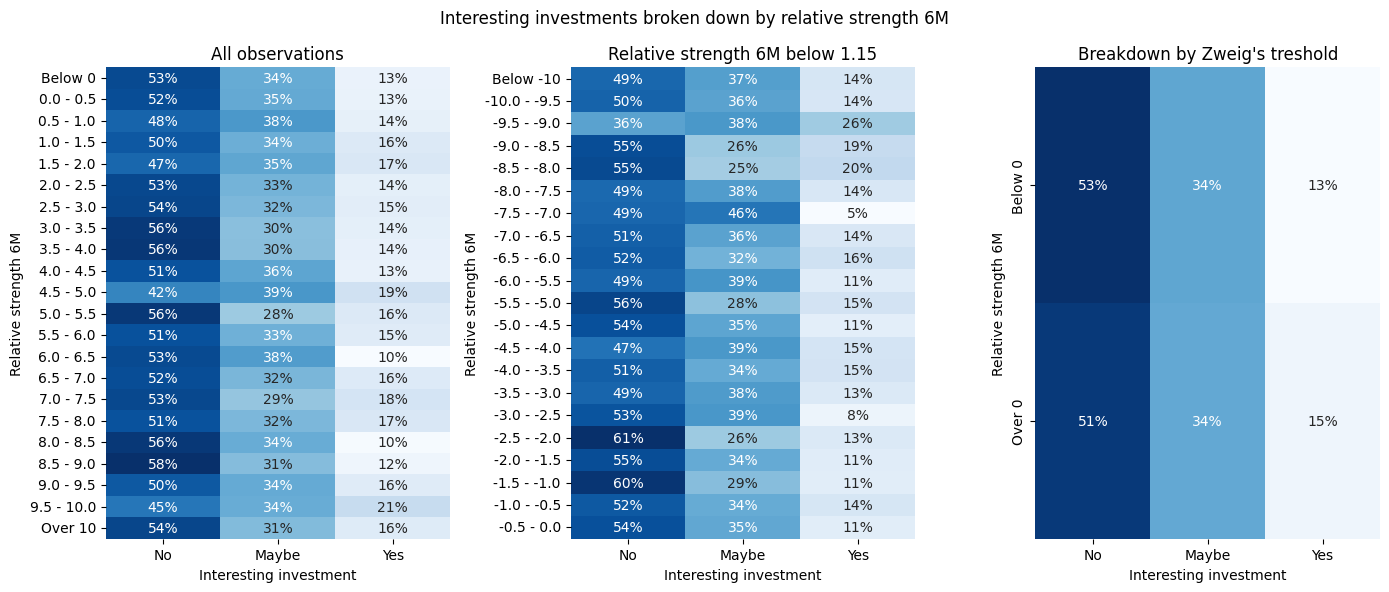

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df.relative_strength_6m,
            bins=[-900] + list(np.arange(0, 10.5, .5)) + [250],
            labels=['Below 0'] + [f'{i} - {i+.5}' for i in np.arange(0, 10, .5)] + ['Over 10']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df[zweig_df.relative_strength_6m < 0].relative_strength_6m,
            bins=[-900] + list(np.arange(-10, .5, .5)),
            labels=['Below -10'] + [f'{i} - {i+.5}' for i in np.arange(-10, 0, .5)]
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df.relative_strength_6m,
            bins=[-900, 0, 250],
            labels=['Below 0', 'Over 0']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[2]
)

for i in range(3):
    axs[i].tick_params(axis='y', labelrotation=0)
    axs[i].set_xlabel('Interesting investment')
    axs[i].set_ylabel('Relative strength 6M')
axs[i].tick_params(axis='y', labelrotation=90)

plt.suptitle('Interesting investments broken down by relative strength 6M')
axs[0].set_title('All observations')
axs[1].set_title('Relative strength 6M below 1.15')
axs[2].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

The last criterion should filter out observations with very high P/E ratio. However, this is a very loose constraint - 94% of observations met this crtiterion. As the charts below indicate, excluded observations performed better than chosen by the strategy.

In general, this criterion does not make any sense - it chooses too many companies with high P/E ratio and, as can be seen in the first boxplot below, the final price dynamics decreased with incresing P/E ratio. Morevoer, the rule of thumb that is used is to choose companies with P/E ratio under 15 or even lower. Such approach excludes about half of observations. The seemingly better idea is to simply choose observations with P/E ratio lower than given value. The charts below indicate treshold of 4.

In [100]:
print('The basic statistics of P/E ratio and average P/E ratio in Zweig\'s strategy:')
print(zweig_df[['price_earnings', 'avg_price_earnings']].describe())
print('\nObservations with P/E ratio lower than doubled average P/E ratio for whole market in given quarter in Zweig\'s strategy:')
print(pd.Series(np.where(
    zweig_df.price_earnings < 2 * zweig_df.avg_price_earnings,
    'Yes', 'No'
)).value_counts())

The basic statistics of P/E ratio and average P/E ratio in Zweig's strategy:
       price_earnings  avg_price_earnings
count        12189.00            12189.00
mean            62.14               58.71
std           1493.52               98.55
min              0.01               15.71
25%              7.75               26.06
50%             12.30               31.98
75%             20.68               50.65
max         130019.98              925.52

Observations with P/E ratio lower than doubled average P/E ratio for whole market in given quarter in Zweig's strategy:
Yes    11485
No       704
dtype: int64


In [119]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

sns.countplot(
    x=pd.cut(
        zweig_df.price_earnings,
        bins=list(np.arange(0, 20.5, .5)) + [2e5],
        labels=[f'{i} - {i+.5}' for i in np.arange(0, 20, .5)] + ['Over 20']
    ),
    color='blue',
    ax=axs[0]
)

sns.countplot(
    x=pd.Series(np.where(
        zweig_df.price_earnings < 2 * zweig_df.avg_price_earnings,
        'Yes', 'No'
    )),
    color='blue',
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel('Count')

axs[0].tick_params(axis='x', labelrotation=90)
axs[0].set_xlabel('P/E ratio')
axs[1].set_xlabel('\n'.join(wrap('P/E ratio lower than doubled average P/E ratio for whole market in given quarter', 60)))

plt.suptitle('Histograms of P/E ratio in Zweig\'s strategy')
axs[0].set_title('All observations')
axs[1].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

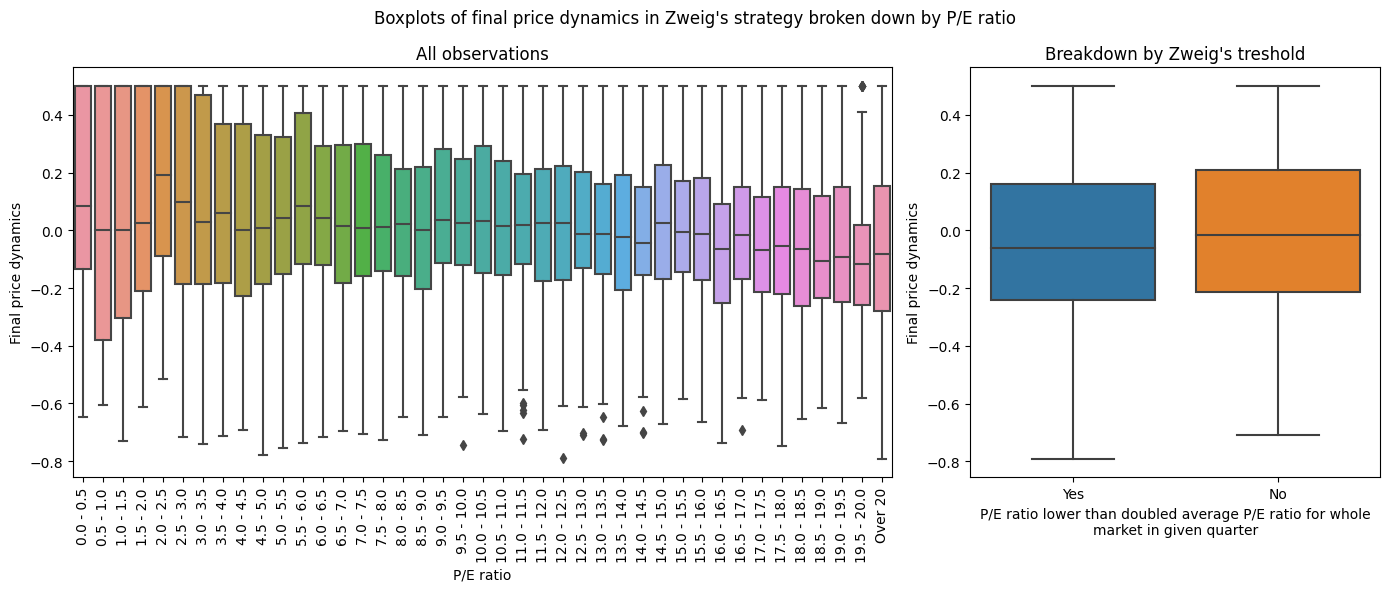

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

sns.boxplot(
    x=pd.cut(
        zweig_df.price_earnings,
        bins=list(np.arange(0, 20.5, .5)) + [2e5],
        labels=[f'{i} - {i+.5}' for i in np.arange(0, 20, .5)] + ['Over 20']
    ),
    y=zweig_df.final_price_dynamics,
    ax=axs[0]
)

sns.boxplot(
    x=pd.Series(np.where(
        zweig_df.price_earnings < 2 * zweig_df.avg_price_earnings,
        'Yes', 'No'
    )),
    y=zweig_df.final_price_dynamics,
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel('Final price dynamics')

axs[0].tick_params(axis='x', labelrotation=90)
axs[0].set_xlabel('P/E ratio')
axs[1].set_xlabel('\n'.join(wrap('P/E ratio lower than doubled average P/E ratio for whole market in given quarter', 60)))

plt.suptitle('Boxplots of final price dynamics in Zweig\'s strategy broken down by P/E ratio')
axs[0].set_title('All observations')
axs[1].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [2, 1]})

custom_heatmap(
    pd.crosstab(
        pd.cut(
            zweig_df.price_earnings,
            bins=list(np.arange(0, 20.5, .5)) + [2e5],
            labels=[f'{i} - {i+.5}' for i in np.arange(0, 20, .5)] + ['Over 20']
        ),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[0]
)

custom_heatmap(
    pd.crosstab(
        pd.Series(np.where(
            zweig_df.price_earnings < 2 * zweig_df.avg_price_earnings,
            'Yes', 'No'
        )),
        zweig_df.interesting_investment,
        normalize='index'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    axs[1]
)

for i in range(2):
    axs[i].set_xlabel('Interesting investment')

axs[0].set_ylabel('P/E ratio')
axs[1].set_ylabel('\n'.join(wrap('P/E ratio lower than doubled average P/E ratio for whole market in given quarter', 60)))

plt.suptitle('Interesting investments broken down by P/E ratio')
axs[0].set_title('All observations')
axs[1].set_title('Breakdown by Zweig\'s treshold')

plt.tight_layout();

In [131]:
# Add column 'mod_buy' for observations, which meet modified strategy conditions
zweig_df['mod_buy'] = np.where(
    (zweig_df.net_earnings_yy > 1.15) &
    (zweig_df.net_earnings_yy < 7) &
    (zweig_df.sales_revenues_yy > .2) &
    (zweig_df.sales_revenues_yy < 1.4) &
    (zweig_df.net_earnings_1Q > zweig_df.net_earnings_5Q) &
    (zweig_df.net_earnings_2Q > zweig_df.net_earnings_6Q) &
    (zweig_df.sales_revenues_1Q > zweig_df.sales_revenues_5Q) &
    (zweig_df.sales_revenues_2Q > zweig_df.sales_revenues_6Q) &
    (zweig_df.relative_strength_6m > 0) &
    (zweig_df.price_earnings < 4),
    'Yes', 'No'
)

print(f'\nNumber of buy signals from modified Zweig\'s strategy: {zweig_df.mod_buy.value_counts()[1]}')


Number of buy signals from modified Zweig's strategy: 23


In [132]:
pd.crosstab(
    zweig_df.interesting_investment,
    zweig_df.mod_buy, 
    rownames=['Interesting investment:'],
    colnames=['Buy signal from modified Zweig\'s strategy:']
).reindex(['No', 'Maybe', 'Yes'], axis=0)

Buy signal from modified Zweig's strategy:    No  Yes
Interesting investment:                              
No                                          6307   11
Maybe                                       4148    4
Yes                                         1711    8